<div style="background-color:white"> <font size="5"> <b> 0. Outline </b> </font> </div>
<div style="background-color:white"> <font size="3"> <b> 1. Introduction </b> </font> </div>
<div style="background-color:white"> <font size="3"> <b> 2. Building the MAI: Mean Aggression Index </b> </font> </div>
<ol>
2.1 	Mean Responsiveness Index: MRI<br>
2.2 	Mean Proximity Index: MPI<br>
2.3 	Mean Positioning Suitability Index: MPSI<br>
Putting pieces together: MAI<br>
</ol>
<div style="background-color:white"> <font size="3"> <b> 3. Experiments and Validation </b> </font> </div>
<div style="background-color:white"> <font size="3"> <b> 4. Conclusions and Potential Developments </b> </font> </div>
<div style="background-color:white"> <font size="3"> <b> Appendix </b> </font> </div>


In [ ]:
'''Libraries to manipulate data'''
import numpy as np
import pandas as pd
import os
import math
import copy
import glob
import random
from scipy import stats

'''Libraries for Data Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go 
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")


'''Load NFL Special Teams data'''
tracking2020 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2020.csv')
tracking2019 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2019.csv')
tracking2018 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2018.csv')

plays = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
players = pd.read_csv('../input/nfl-big-data-bowl-2022/players.csv')
games = pd.read_csv('../input/nfl-big-data-bowl-2022/games.csv')
scoutingData = pd.read_csv('../input/nfl-big-data-bowl-2022/PFFScoutingData.csv')
                           

# 1. Introduction

Special Teams are composed by players who are on the field during kicking plays. We are thus dealing with kickers, punters, long-snappers, and other roles mainly involved in kick and return activities (including coverage, an aspect that we will investigate carefully).
The possible plays that are carried out by Special Teams are Kickoff, Punt, Field Goal, and Extra Point; for our purposes, we will take into account Kickoffs and Punts with Return outcome. In these plays, the receiving team gets the ball and advances through the field, trying a touchdown; to avoid this, the kicking team tries to tackle the ball carrier, hence the receiving team is entitled to protect the ball carrier by creating real barriers that cover opponent players and prevent them to tackle the returning player. 

What we are going to explore is the impact an aggressive defense to protect the ball carrier in Return-outcome Kicking Plays has on the play result (i.e., on the number of yards gained by the returning team), and how to actually quantify such aggressive defense through the adoption of a 3-step assessment metric.

# 2. Building the MAI: Mean Aggression Index



## 2.1 Mean Responsiveness Index: MRI

The Mean Responsiveness Index is mainly about the Acceleration attributes of players in Return Kicking plays. We can define it as follows:

<div style='text-align:center'><font size=4> $MRI = \frac{1}{N}	\sum_{i=1}^{N}max_{a_{i,t}}, t \in [t_{0}, t_{end}] $</font></div><br>


Where:
- $N$ is the Number of non-ball carrier players in the returning team (i.e., 10);
- $i$ represents a player of the Team;
- $t$ represents a specific second of a play;
- $t_{0}$ represents the time at which the receiving team takes the ball and starts the return;
- $t_{end}$ denotes the end of the play;
- $a$ represents the acceleration feature of player $i$ at time $t$.

Each Responsiveness Index represents the maximum acceleration reached by a player during a play and, more specifically, between the return start $t_{0}$ and its end $t_{end}$; the MRI averages the Responsiveness Indices of all the players of a Special Team. The rationale behind including this metric relies on the implications a powerful acceleration during the Return timeframe (between $t_{0}$ and $t_{end}$) has in terms of Responsiveness: a defensive player with an explosive acceleration interposing himself between the ball carrier and a dangerous opponent player might prevent a fatal tackle to occur, and this can hugely affect the result of a play.

## 2.2 Mean Proximity Index: MPI

Even though responsive players are more likely to effectively keep pushing against opponent tacklers, other factors kick in when evaluating the actual effect of Proximity. Indeed, a low-responsiveness player can still be effective in defending the ball carrier and move opponent players away from the returner if able to exert a constant pressure on them; similarly, a high-responsiveness player not properly covering opponent players may lead the returning team to a fateful outcome. Despite having some relationship with MRI, the MPI thus takes into account playing factors of Return Kicking plays that are completely unrelated to MRI, as well.

To obtain the Mean Proximity Index, a clustering process is applied, with some assumptions that must hold in order for the whole picture to be consistent. 
- The number of clusters is equal to 11, with each player of the kicking team representing a single cluster centroid;
- Each player of the receiving team is clustered and associated to a player of the kicking team (who represents his cluster's Centroid) after a certain time frame $\epsilon$ (we set it at one second after the Return starts), and then re-clustered after every half a second to make the MPI account for eventual coverage variations;
- Clustering is performed each second after a player of the receiving team (who will be the returner) takes the ball, using $x$ and $y$ features;
- The Mean Proximity Index is obtained as a revisited Within-Cluster Sum of Squares (WCSS), i.e., the Within-Cluster Average Distance, averaged over all the time frames between $t_{0} + \epsilon$ and $t_{end, \sigma}$; the WCAD is obtained by averaging the Euclidean Distance between each receiving team player and the associated clustering centroid, i.e., the kicking team player to cover.

Hence, we obtain the Mean Proximity Index MPI as follows:

<div style='text-align:center'><font size=3> $MPI = \frac{1}{t_{end, \sigma}-(t_{0}+\epsilon)}	\sum_{t=t_{0}+\epsilon}^{t_{end, \sigma}}WCAD_{t}  ;$</font></div><br>

<div style='text-align:center'><font size=3> $WCAD_{t} = \frac{1}{n-\delta}\sum_{i=1}^{n-\delta}\frac{1}{m}\sum_{j=1}^{m}	Euclidean Distance(P_{i, j}^{r},P_{i}^{k})_{t};$</font></div><br>

<div style='text-align:center'><font size=3> $\implies MPI = \frac{1}{t_{end, \sigma}-(t_{0}+\epsilon)}	\sum_{t=t_{0}+\epsilon}^{t_{end, \sigma}}\frac{1}{n-\delta}\sum_{i=1}^{n-\delta}\frac{1}{m}\sum_{j=1}^{m}	Euclidean Distance(P_{i, j}^{r},P_{i}^{k})_{t}$</font></div><br>

Where:
- $n - \delta$ is the number of clusters with cardinality $|i|$ greater than or equal to 2; in fact, $n$ is the number of total clusters (i.e., 11), while $\delta$ is the number of clusters inapplicable to account for MPI computation, i.e., clusters composed only by a kicking team player, representing an opponent player left uncovered;
- $m$ is the number of total receiving players in a cluster that contains at least one receiving player; $j$ denotes a specific receiving player belonging to cluster number $i$;
- $r$  superscript denotes the Player of the receiving team belonging to cluster $i$, hence assigned to covering the Player of the kicking team, denoted by $k$ superscript, belonging to the same cluster;
- $t_{end,\sigma}$ denotes the end of tracking data processing for assessment purposes: if the number of time frames after $t_{0} + \epsilon$ is lower than $\sigma$, then it represents the end of the play; if there are more than $\sigma$ time frames available, then the metric will only be computed until time frame $t_{end, \sigma}$ is reached. We will set the time frame limit factor $\sigma$ equal to 50 time frames;
- $\epsilon$ represents a lagging factor that allows to take into account the desired metrics only from a relevant moment of the play onwards; $t_{0} + \epsilon$ thus indicates the starting point of metrics recording, when players reacted to the start of the return and acted accordingly.

Note: for MPI, the lower, the better.

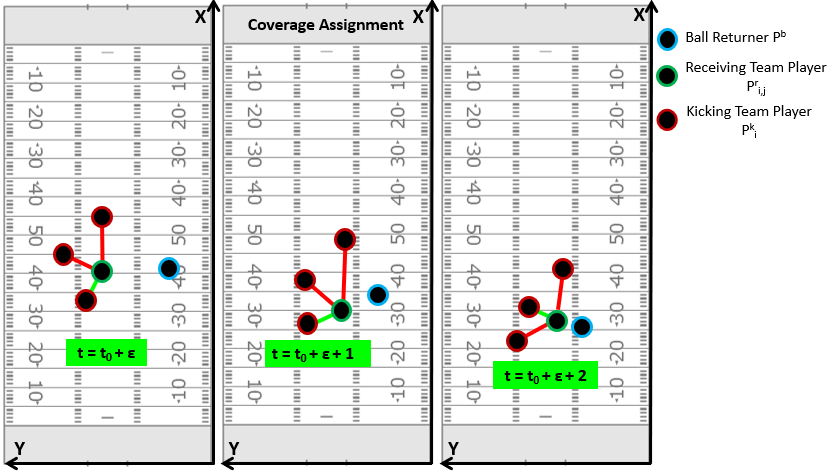


### 2.3 Mean Positioning Suitability Index: MPSI

A receiving player might exhibit high proximity values (low MPI) for the great majority of a return, but this may not be enough if the tackling player still has a crack on the ball carrier; the Mean Positioning Suitability Index aims at quantifying how much suitable, in terms of ball carrier protection, the positioning of receiving players are during return kicking plays, regardless of their proximity to the opponent players they are covering.

We obtain the metric as follows:

<div style='text-align:center'><font size=2> $MPSI = \frac{1}{t_{end, \sigma}-(t_{0}+\epsilon)}\sum_{t=t_{0}+\epsilon}^{t_{end, \sigma}}	\frac{1}{c}	\sum_{h=1}^{c}PSI_{h,t};  $</font></div><br>

<div style='text-align:center'><font size=2> $PSI_{h,t} = cos^{-1}\frac{EuclideanDistance(P_{h}^{k}, P_{h}^{r})^{2}_{t} + EuclideanDistance(P^{b}, P_{h}^{r})^{2}_{t} - EuclideanDistance(P^{b}, P_{i}^{k})^{2}_{t}}{2EuclideanDistance(P_{h}^{k}, P_{h}^{r})_{t} \times EuclideanDistance(P^{b}, P_{h}^{r})_{t}};  $</font></div><br>

<div style='text-align:center'><font size=2> $\implies MPSI = \frac{1}{t_{end, \sigma}-(t_{0}+\epsilon)}\sum_{t=t_{0}+\epsilon}^{t_{end, \sigma}}	\frac{1}{c}	\sum_{h=1}^{c}cos^{-1}(\frac{EuclideanDistance(P_{h}^{k}, P_{h}^{r})^{2}_{t} + EuclideanDistance(P^{b}, P_{h}^{r})_{t}^{2} - EuclideanDistance(P^{b}, P_{h}^{k})^{2}_{t}}{2EuclideanDistance(P_{h}^{k}, P_{h}^{r})_{t} \times EuclideanDistance(P^{b}, P_{h}^{r})_{t}})   $</font></div><br>

Where:
- $b$ superscript denotes the ball carrier player;
- $c$ represents the set of all possible combinations of receiving team player and kicking team player, established in the clustering process;
- $r$ and $k$ superscripts denote, respectively, the player of the receiving team and the player of the kicking team belonging to the combination number $h$ established in the clustering process; unlike for the MPI, PSI will not be averaged between all the receiving players of the same cluster this time;

The idea behind the MPSI basically consists in taking, for each couple Receiving Player $P_{i}^{r}$-Kicking Team Player to be covered $P_{i}^{k}$, the angle that forms between the straight line that connects the receiving team ball carrier $P^{b}$ and the given receiving player $P_{i}^{r}$, and the straight line connecting the receiving player $P_{i}^{r}$ to the kicking team player to be covered $P_{i}^{k}$. Given that the straight lines represent distances we can derive from tracking data, trigonometry allows us to easily derive our desired angle. As the following figure shows, the closer the angle is to 180, the more suitable the receiving player's position is to defend the ball carrier from any eventual intrusion carried out by the kicking team player; any change that leads to a less suitable positioning leads to a decrease in the angle, hence in the PSI.

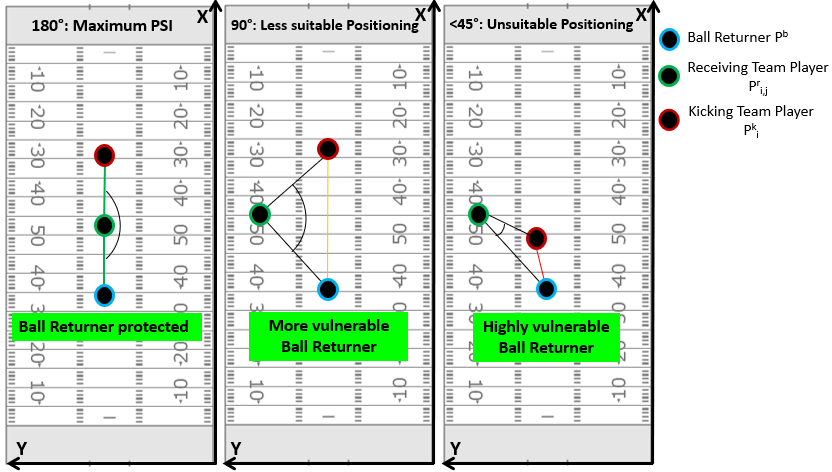

## Putting pieces together: MAI

<div style='text-align:center'><font size=3> $MAI = \gamma(nMRI) + \lambda(nMPSI) + \phi(1 - nMPI) $;</font></div><br>

<div style='text-align:center'><font size=3> $normalizedMetric = \frac{RawMetric - RawMetric_{min}}{RawMetric_{max} - RawMetric_{min}} $;</font></div><br>

<div style='text-align:center'><font size=3>$\implies MAI = \gamma(\frac{MRI - MRI_{min}}{MRI_{max} - MRI_{min}}) + \lambda(\frac{MPSI - MPSI_{min}}{MPSI_{max} - MPSI_{min}}) + \phi(1 - \frac{MPI - MPI_{min}}{MPI_{max} - MPI_{min}})$,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$MAI \in [0, 1]$</font></div><br>


Where:
- $max$ and $min$ subscripts represent, respectively, the maximum and the minimum value of the non-normalized metric ever encountered in the three season of available tracking data, i.e., 2018, 2019 and 2020;
- $\gamma$, $\lambda$, and $\phi$ are coefficients indicating how much each sub-metric contributes to the Mean Aggression Index.

Note: the purpose of normalizing each sub-metric is to yield evaluation measures in the same scale, i.e., between 0 and 1, easing the MAI computation process and making it fit in the [0, 1] interval, as well.

In [ ]:
'''Define auxiliary functions to compute the developed metrics'''
def getDistance(x1, y1, x2, y2, squared=False): 
    if squared == False:
        euclideanDistance = math.sqrt((y2-y1)**2 + (x2-x1)**2)
    else:
        euclideanDistance = (y2-y1)**2 + (x2-x1)**2
    return euclideanDistance

def getDefendingTeam(trackingData_byPlay):
    gameId = trackingData_byPlay['gameId'].reset_index(drop=True)[0]
    playId = trackingData_byPlay['playId'].reset_index(drop=True)[0]
    kickerId = plays[plays['playId'] == playId][plays['gameId'] == gameId]['kickerId'].reset_index(drop=True)[0]
    nonreturningTeam = trackingData_byPlay[trackingData_byPlay['nflId'] == kickerId]['team'].reset_index(drop=True)[0]
    if nonreturningTeam == "away":
        returningTeam = "home"
    if nonreturningTeam == "home":
        returningTeam = "away"
    return returningTeam

def detectReturner(trackingData_byPlay):
    if plays[plays['playId'] == trackingData_byPlay['playId'].reset_index(drop=True)[0]][plays['gameId'] == trackingData_byPlay['gameId'].reset_index(drop=True)[0]]['specialTeamsPlayType'].reset_index(drop=True)[0] == 'Punt':
        event = 'punt_received'
    if plays[plays['playId'] == trackingData_byPlay['playId'].reset_index(drop=True)[0]][plays['gameId'] == trackingData_byPlay['gameId'].reset_index(drop=True)[0]]['specialTeamsPlayType'].reset_index(drop=True)[0] == 'Kickoff':
        event = 'kick_received'
    trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['event'] == event]
    if len(trackingData_byPlay['x']) == 0:
        return None
    distances = []
    players = []
    for player in trackingData_byPlay[trackingData_byPlay['team'] != 'football']['nflId']:
        player_data = trackingData_byPlay[trackingData_byPlay['nflId'] == player]
        football_data = trackingData_byPlay[trackingData_byPlay['team'] == 'football']
        dist = getDistance(player_data['x'].reset_index(drop=True)[0], player_data['y'].reset_index(drop=True)[0], football_data['x'].reset_index(drop=True)[0], football_data['y'].reset_index(drop=True)[0])
        distances.append(dist)
        players.append(player)
    returner = players[distances.index(min(distances))]
    return returner

def getReturnStart(trackingData_byPlay, team):
    trackingData_byPlay = trackingData_byPlay.reset_index(drop=True)
    maxFrames = max(trackingData_byPlay['frameId'])
    returnerId = detectReturner(trackingData_byPlay)
    if returnerId == None:
        return None, None
    for frameId in range(1, maxFrames):
        try:
            distance = getDistance(trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['team'] == 'football']['x'].reset_index(drop=True)[0], trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['team'] == 'football']['y'].reset_index(drop=True)[0], trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['nflId'] == returnerId][trackingData_byPlay['team'] == team]['x'].reset_index(drop=True)[0], trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['nflId'] == returnerId][trackingData_byPlay['team'] == team]['y'].reset_index(drop=True)[0])
        except KeyError:
            return None, None
        if distance < 1:
            returnStart = frameId
            break
    try:
        framesAfterStart = maxFrames - returnStart
    except:
        return None, None
    return returnStart, framesAfterStart
    
def computeMRI(trackingData_byPlay, team):
    returnStart, framesAfterStart = getReturnStart(trackingData_byPlay, team)
    if returnStart == None:
        return None
    returnerId = detectReturner(trackingData_byPlay)
    trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['team'] == team][trackingData_byPlay['nflId'] != returnerId]
    ResponsivenessIndices = []
    if framesAfterStart < 15:
        return None
    else:
        trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['frameId'] >= returnStart]
        for player in trackingData_byPlay['displayName'].unique():
            trackingData_byPlay_player = trackingData_byPlay[trackingData_byPlay['displayName'] == player]
            ResponsivenessIndices.append(max(trackingData_byPlay_player['a']))
    MRI = sum(ResponsivenessIndices) / len(ResponsivenessIndices)
    return MRI

def computeMPI_MPSI(trackingData_byPlay, team, frames_batch=5, frames_limit=50):
    returnStart, framesAfterStart = getReturnStart(trackingData_byPlay, team)
    if returnStart == None:
        return None, None
    returnerId = detectReturner(trackingData_byPlay)
    trackingData_byPlay_ballcarrier = trackingData_byPlay[trackingData_byPlay['nflId'] == returnerId]
    trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['nflId'] != returnerId]
    ProximityIndices = []
    PositioningSuitabilityIndices = []
    if framesAfterStart < 15:
        return None, None
    else:
        trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['frameId'] >= returnStart + 10]
        interval = frames_batch
        for frame in trackingData_byPlay['frameId']:
            if frame - (returnStart + 10) > frames_limit:
                break
            interval += 1
            if interval < frames_batch:
                continue
            '''Compute Proximity Index per time frame'''
            trackingData_byPlay_framed = trackingData_byPlay[trackingData_byPlay['frameId'] == frame]
            centroidOpponents = {}
            combinations = [] #store for MPSI
            for player in trackingData_byPlay_framed[trackingData_byPlay_framed['team'] == team]['displayName']:
                trackingData_byPlay_framed_player = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == player]
                distances = []
                players = []
                for opponentPlayer in trackingData_byPlay_framed[trackingData_byPlay_framed['team'] != team][trackingData_byPlay_framed['team'] != 'football']['displayName'].unique():
                    trackingData_byPlay_framed_opponent = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == opponentPlayer]
                    distances.append(getDistance(trackingData_byPlay_framed_player['x'].reset_index(drop=True)[0], trackingData_byPlay_framed_player['y'].reset_index(drop=True)[0], trackingData_byPlay_framed_opponent['x'].reset_index(drop=True)[0], trackingData_byPlay_framed_opponent['y'].reset_index(drop=True)[0]))
                    players.append(trackingData_byPlay_framed_opponent['displayName'].reset_index(drop=True)[0])
                covered = players[distances.index(min(distances))]
                if covered in centroidOpponents:
                    centroidOpponents[covered].append(min(distances))
                else:
                    centroidOpponents[covered] = [min(distances)]
                combinations.append((players[distances.index(min(distances))], player))
            byCluster = []
            for covered in centroidOpponents:
                byCluster.append(sum(centroidOpponents[covered]) / len(centroidOpponents[covered]))
            ProximityIndices.append(sum(byCluster) / len(byCluster))
            '''Compute Positioning Suitability Index per time frame'''
            trackingData_byPlay_ballcarrier_framed = trackingData_byPlay_ballcarrier[trackingData_byPlay_ballcarrier['frameId'] == frame]
            X_Pb = trackingData_byPlay_ballcarrier_framed['x'].reset_index(drop=True)[0]
            Y_Pb = trackingData_byPlay_ballcarrier_framed['y'].reset_index(drop=True)[0]
            X_Pbtsigma = X_Pb + math.sin(trackingData_byPlay_ballcarrier_framed['dir'].reset_index(drop=True)[0])
            Y_Pbtsigma = Y_Pb + math.cos(trackingData_byPlay_ballcarrier_framed['dir'].reset_index(drop=True)[0])
            PSI = []
            CoveredPlayers = []
            for combination in combinations:
                Pk = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == combination[0]]
                X_Pk = Pk['x'].reset_index(drop=True)[0]
                Y_Pk = Pk['y'].reset_index(drop=True)[0]
                Pr = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == combination[1]]
                X_Pr = Pr['x'].reset_index(drop=True)[0]
                Y_Pr = Pr['y'].reset_index(drop=True)[0]
                cosine = (getDistance(X_Pk,Y_Pk,X_Pr,Y_Pr,squared=True)+getDistance(X_Pb,Y_Pb,X_Pr,Y_Pr,squared=True)-getDistance(X_Pb,Y_Pb,X_Pk,Y_Pk,squared=True))/(2*(getDistance(X_Pk,Y_Pk,X_Pr,Y_Pr)*getDistance(X_Pb,Y_Pb,X_Pr,Y_Pr)))
                if cosine > 1 and cosine < 1.2:
                    cosine = 1
                if cosine < -1 and cosine > -1.2:
                    cosine = -1
                PSI_Degrees = math.degrees(math.acos(cosine))
                PSI.append(PSI_Degrees)
                CoveredPlayers.append(combination[0])
            PositioningSuitabilityIndices.append(sum(PSI) / len(PSI))
            interval = 0
    MPI = sum(ProximityIndices) / len(ProximityIndices)
    MPSI = sum(PositioningSuitabilityIndices) / len(PositioningSuitabilityIndices)
    
    interval = frames_batch
    store = []
    
    return MPI, MPSI
            
def buildMAI(df, team):
    MRI = computeMRI(df, team)
    MPI, MPSI = computeMPI_MPSI(df, team)
    
    if MRI == None or MPI == None or MPSI == None:
        return None, None, None, None
    MAI = 0 #####
    return MAI, MRI, MPI, MPSI #####

def ComputeAndStoreMAI_byPlay(trackingData, playId):
    gameId = trackingData['gameId'].reset_index(drop=True)[0]
    
    homeAbbr = games[games['gameId'] == gameId]['homeTeamAbbr'].reset_index(drop=True)[0]
    visitorAbbr = games[games['gameId'] == gameId]['visitorTeamAbbr'].reset_index(drop=True)[0]
    
    trackingData_byPlay = trackingData[trackingData['playId']== playId]
    MAI, MRI, MPI, MPSI = buildMAI(trackingData_byPlay, getDefendingTeam(trackingData_byPlay))
    YardsByPlay = plays[plays['playId']==playId][plays['gameId']==gameId]['kickReturnYardage'].reset_index(drop=True)[0]
    return MAI, MRI, MPI, MPSI, YardsByPlay, getDefendingTeam(trackingData_byPlay), visitorAbbr, homeAbbr


In [ ]:
#2020
games_rawMetrics2020 = pd.read_csv("../input/nfl-2022-processed-data/games_stored2020.csv")

gamma_ = 0.2
lambda_ = 0.45
phi_ = 0.35

minmaxMetrics2018_2019_2020 = {'MaxMRI': 6.7540000000000004,
 'MinMRI': 1.5370000000000001,
 'MaxMPI': 11.658249870954279,
 'MinMPI': 0.8690253143061738,
 'MaxMPSI': 131.28043201108832,
 'MinMPSI': 27.789299614347524}

minmaxMetrics2020 = {'MaxMRI': 0.0,
 'MinMRI': 9999.0,
 'MaxMPI': 0.0,
 'MinMPI': 9999.0,
 'MaxMPSI': 0.0,
 'MinMPSI': 9999.0}

for game in games_rawMetrics2020['games']:
    game_Strings = game[2:-2].split("], [")
    if len(game_Strings) <= 1:
        continue
    for playString in game_Strings:
        play = playString[1:-1].split(", ")
        if play[1] == "None" or play[4] == "nan":
            continue
        if float(play[1]) > minmaxMetrics2020['MaxMRI']:
            minmaxMetrics2020['MaxMRI'] = float(play[1])
        if float(play[1]) < minmaxMetrics2020['MinMRI']:
            minmaxMetrics2020['MinMRI'] = float(play[1])
        if float(play[2]) > minmaxMetrics2020['MaxMPI']:
            minmaxMetrics2020['MaxMPI'] = float(play[2])
        if float(play[2]) < minmaxMetrics2020['MinMPI']:
            minmaxMetrics2020['MinMPI'] = float(play[2])
        if float(play[3]) > minmaxMetrics2020['MaxMPSI']:
            minmaxMetrics2020['MaxMPSI'] = float(play[3])
        if float(play[3]) < minmaxMetrics2020['MinMPSI']:
            minmaxMetrics2020['MinMPSI'] = float(play[3])
            
MAI_byTeam = {}
MAI_byPlay = []
gameCount = 0
gamesToSkip = []
gamesToSkip_counter = 0
playsToSkip = []
playsToSkip_counter = 0
for game in games_rawMetrics2020['games']:
    game_Strings = game[2:-2].split("], [")
    if len(game_Strings) <= 1:
        gamesToSkip.append(gamesToSkip_counter)
        gamesToSkip_counter += 1
        continue
    game_Plays_adjusted = []
    gamesToSkip_counter += 1
    for playString in game_Strings:
        play = playString[1:-1].split(", ")
        if play[1] == "None" or play[4] == "nan":
            playsToSkip.append(playsToSkip_counter)
            playsToSkip_counter += 1
            continue
        playsToSkip_counter += 1
        nMRI = round((float(play[1]) - minmaxMetrics2018_2019_2020['MinMRI']) / (minmaxMetrics2018_2019_2020['MaxMRI'] - minmaxMetrics2018_2019_2020['MinMRI']), 3)
        nMPI = round((float(play[2]) - minmaxMetrics2018_2019_2020['MinMPI']) / (minmaxMetrics2018_2019_2020['MaxMPI'] - minmaxMetrics2018_2019_2020['MinMPI']), 3)
        nMPSI = round((float(play[3]) - minmaxMetrics2018_2019_2020['MinMPSI']) / (minmaxMetrics2018_2019_2020['MaxMPSI'] - minmaxMetrics2018_2019_2020['MinMPSI']), 3)
        MAI = round(gamma_*nMRI + lambda_*nMPSI + phi_*(1 - nMPI), 3)

        game_Plays_adjusted.append([MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]])
        MAI_byPlay.append((MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]))
    
GameIDs = []
PlayIDs = []
counter1 = 0
counter2 = 0
for gameId in games[games['season']==2020]['gameId']:
    ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]
    if counter1 in gamesToSkip:
        counter1 += 1
        continue
    counter1 += 1
    for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
        if counter2 in playsToSkip:
            counter2 += 1
            continue
        if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
            counter2 += 1
            continue
        counter2 += 1
        GameIDs.append(gameId)
        PlayIDs.append(playId)
        
MAI_byPlay_df = pd.DataFrame(MAI_byPlay, columns=['MAI','MRI','MPI','MPSI','YardsGained','ReturningTeam','AwayTeam','HomeTeam'])
MAI_byPlay_df['gameId'] = GameIDs
MAI_byPlay_df['playId'] = PlayIDs

#_____________________________________
#2019
games_rawMetrics2019 = pd.read_csv("../input/nfl-2022-processed-data/games_stored2019.csv")

minmaxMetrics2019 = {'MaxMRI': 0.0,
 'MinMRI': 9999.0,
 'MaxMPI': 0.0,
 'MinMPI': 9999.0,
 'MaxMPSI': 0.0,
 'MinMPSI': 9999.0}

for game in games_rawMetrics2019['games']:
    game_Strings = game[2:-2].split("], [")
    if len(game_Strings) <= 1:
        continue
    for playString in game_Strings:
        play = playString[1:-1].split(", ")
        if play[1] == "None" or play[4] == "nan":
            continue
        if float(play[1]) > minmaxMetrics2019['MaxMRI']:
            minmaxMetrics2019['MaxMRI'] = float(play[1])
        if float(play[1]) < minmaxMetrics2019['MinMRI']:
            minmaxMetrics2019['MinMRI'] = float(play[1])
        if float(play[2]) > minmaxMetrics2019['MaxMPI']:
            minmaxMetrics2019['MaxMPI'] = float(play[2])
        if float(play[2]) < minmaxMetrics2019['MinMPI']:
            minmaxMetrics2019['MinMPI'] = float(play[2])
        if float(play[3]) > minmaxMetrics2019['MaxMPSI']:
            minmaxMetrics2019['MaxMPSI'] = float(play[3])
        if float(play[3]) < minmaxMetrics2019['MinMPSI']:
            minmaxMetrics2019['MinMPSI'] = float(play[3])
            
MAI_byTeam = {}
MAI_byPlay2019 = []
gameCount = 0
gamesToSkip = []
gamesToSkip_counter = 0
playsToSkip = []
playsToSkip_counter = 0
for game in games_rawMetrics2019['games']:
    game_Strings = game[2:-2].split("], [")
    if len(game_Strings) <= 1:
        gamesToSkip.append(gamesToSkip_counter)
        gamesToSkip_counter += 1
        continue
    game_Plays_adjusted = []
    gamesToSkip_counter += 1
    for playString in game_Strings:
        play = playString[1:-1].split(", ")
        if play[1] == "None" or play[4] == "nan":
            playsToSkip.append(playsToSkip_counter)
            playsToSkip_counter += 1
            continue
        playsToSkip_counter += 1
        nMRI = round((float(play[1]) - minmaxMetrics2018_2019_2020['MinMRI']) / (minmaxMetrics2018_2019_2020['MaxMRI'] - minmaxMetrics2018_2019_2020['MinMRI']), 3)
        nMPI = round((float(play[2]) - minmaxMetrics2018_2019_2020['MinMPI']) / (minmaxMetrics2018_2019_2020['MaxMPI'] - minmaxMetrics2018_2019_2020['MinMPI']), 3)
        nMPSI = round((float(play[3]) - minmaxMetrics2018_2019_2020['MinMPSI']) / (minmaxMetrics2018_2019_2020['MaxMPSI'] - minmaxMetrics2018_2019_2020['MinMPSI']), 3)
        MAI = round(gamma_*nMRI + lambda_*nMPSI + phi_*(1 - nMPI), 3)

        game_Plays_adjusted.append([MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]])
        MAI_byPlay2019.append((MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]))
    
GameIDs = []
PlayIDs = []
counter1 = 0
counter2 = 0
for gameId in games[games['season']==2019]['gameId']:
    ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]
    if counter1 in gamesToSkip:
        counter1 += 1
        continue
    counter1 += 1
    for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
        if counter2 in playsToSkip:
            counter2 += 1
            continue
        if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
            counter2 += 1
            continue
        counter2 += 1
        GameIDs.append(gameId)
        PlayIDs.append(playId)
        
MAI_byPlay_df2019 = pd.DataFrame(MAI_byPlay2019, columns=['MAI','MRI','MPI','MPSI','YardsGained','ReturningTeam','AwayTeam','HomeTeam'])
MAI_byPlay_df2019['gameId'] = GameIDs
MAI_byPlay_df2019['playId'] = PlayIDs


#_____________________________________
#2018
games_rawMetrics2018 = pd.read_csv("../input/nfl-2022-processed-data/games_stored2018.csv")

minmaxMetrics2018 = {'MaxMRI': 0.0,
 'MinMRI': 9999.0,
 'MaxMPI': 0.0,
 'MinMPI': 9999.0,
 'MaxMPSI': 0.0,
 'MinMPSI': 9999.0}

for game in games_rawMetrics2018['games']:
    game_Strings = game[2:-2].split("], [")
    if len(game_Strings) <= 1:
        continue
    for playString in game_Strings:
        play = playString[1:-1].split(", ")
        if play[1] == "None" or play[4] == "nan":
            continue
        if float(play[1]) > minmaxMetrics2018['MaxMRI']:
            minmaxMetrics2018['MaxMRI'] = float(play[1])
        if float(play[1]) < minmaxMetrics2018['MinMRI']:
            minmaxMetrics2018['MinMRI'] = float(play[1])
        if float(play[2]) > minmaxMetrics2018['MaxMPI']:
            minmaxMetrics2018['MaxMPI'] = float(play[2])
        if float(play[2]) < minmaxMetrics2018['MinMPI']:
            minmaxMetrics2018['MinMPI'] = float(play[2])
        if float(play[3]) > minmaxMetrics2018['MaxMPSI']:
            minmaxMetrics2018['MaxMPSI'] = float(play[3])
        if float(play[3]) < minmaxMetrics2018['MinMPSI']:
            minmaxMetrics2018['MinMPSI'] = float(play[3])
            
MAI_byTeam = {}
MAI_byPlay2018 = []
gameCount = 0
gamesToSkip = []
gamesToSkip_counter = 0
playsToSkip = []
playsToSkip_counter = 0
for game in games_rawMetrics2018['games']:
    game_Strings = game[2:-2].split("], [")
    if len(game_Strings) <= 1:
        gamesToSkip.append(gamesToSkip_counter)
        gamesToSkip_counter += 1
        continue
    game_Plays_adjusted = []
    gamesToSkip_counter += 1
    for playString in game_Strings:
        play = playString[1:-1].split(", ")
        if play[1] == "None" or play[4] == "nan":
            playsToSkip.append(playsToSkip_counter)
            playsToSkip_counter += 1
            continue
        playsToSkip_counter += 1
        nMRI = round((float(play[1]) - minmaxMetrics2018_2019_2020['MinMRI']) / (minmaxMetrics2018_2019_2020['MaxMRI'] - minmaxMetrics2018_2019_2020['MinMRI']), 3)
        nMPI = round((float(play[2]) - minmaxMetrics2018_2019_2020['MinMPI']) / (minmaxMetrics2018_2019_2020['MaxMPI'] - minmaxMetrics2018_2019_2020['MinMPI']), 3)
        nMPSI = round((float(play[3]) - minmaxMetrics2018_2019_2020['MinMPSI']) / (minmaxMetrics2018_2019_2020['MaxMPSI'] - minmaxMetrics2018_2019_2020['MinMPSI']), 3)
        MAI = round(gamma_*nMRI + lambda_*nMPSI + phi_*(1 - nMPI), 3)

        game_Plays_adjusted.append([MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]])
        MAI_byPlay2018.append((MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]))
    
GameIDs = []
PlayIDs = []
counter1 = 0
counter2 = 0
for gameId in games[games['season']==2018]['gameId']:
    ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]
    if counter1 in gamesToSkip:
        counter1 += 1
        continue
    counter1 += 1
    for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
        if counter2 in playsToSkip:
            counter2 += 1
            continue
        if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
            counter2 += 1
            continue
        counter2 += 1
        GameIDs.append(gameId)
        PlayIDs.append(playId)
        
MAI_byPlay_df2018 = pd.DataFrame(MAI_byPlay2018, columns=['MAI','MRI','MPI','MPSI','YardsGained','ReturningTeam','AwayTeam','HomeTeam'])
MAI_byPlay_df2018['gameId'] = GameIDs
MAI_byPlay_df2018['playId'] = PlayIDs

# 3. Experiments and Validation

Let us now carry out an analysis of the developed metrics and how these metrics practically affect the Return Kicking plays' result, i.e., the yards gained by the returning team. Returns indeed aim at gaining ground that is measured in yards, and a higher yardage gain usually represents a better Return outcome. We will thus make use of statistical techniques to make experiments and highlight distributive differences in the data (e.g., Yards gain in high MRI plays vs Yards gain in low MRI plays) to validate, using data from all the seasons from 2018 to 2020, each of the proposed sub-metrics and, ultimately, the MAI.


### 3.1 Mean Responsiveness Index

In [ ]:
'''Statistical Tests and Distribution Plots - MRI'''
highValue = MAI_byPlay_df[MAI_byPlay_df['MRI'] >= 0.575]
lowValue = MAI_byPlay_df[MAI_byPlay_df['MRI'] < 0.575]

highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MRI'] >= 0.575]
lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MRI'] < 0.575]

highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MRI'] >= 0.575]
lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MRI'] < 0.575]

alpha = 0.05

stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
if p > alpha:
    outcome = 'Test Outcome:<br>Same distributions'
else:
    outcome = 'Test Outcome:<br>Different distributions'
if p < 0.001:
    p = "<0.0001"
    
stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
if p2019 > alpha:
    outcome2019 = 'Test Outcome:<br>Same distributions'
else:
    outcome2019 = 'Test Outcome:<br>Different distributions'
if p2019 < 0.001:
    p2019 = "<0.0001"
else:
    p2019 = round(p2019, 3)
    
stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
if p2018 > alpha:
    outcome2018 = 'Test Outcome:<br>Same distributions'
else:
    outcome2018 = 'Test Outcome:<br>Different distributions'
if p2018 < 0.001:
    p2018 = "<0.0001"
else:
    p2018 = round(p2018, 3)
    
highValue2 = pd.DataFrame()
highValue2['YardsGained'] = highValue['YardsGained']
highValue2['MRI'] = 'High'
lowValue2 = pd.DataFrame()
lowValue2['YardsGained'] = lowValue['YardsGained']
lowValue2['MRI'] = 'Low'

highValue2019_2 = pd.DataFrame()
highValue2019_2['YardsGained'] = highValue2019['YardsGained']
highValue2019_2['MRI'] = 'High'
lowValue2019_2 = pd.DataFrame()
lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
lowValue2019_2['MRI'] = 'Low'

highValue2018_2 = pd.DataFrame()
highValue2018_2['YardsGained'] = highValue2018['YardsGained']
highValue2018_2['MRI'] = 'High'
lowValue2018_2 = pd.DataFrame()
lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
lowValue2018_2['MRI'] = 'Low'

MRI_plays = pd.concat([highValue2, lowValue2])
MRI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
MRI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

bp1 = px.box(MRI_plays, x='MRI', y="YardsGained")
bp1.data[0].marker.color = 'black'

bp2 = px.box(MRI_plays2019, x='MRI', y="YardsGained")
bp2.data[0].marker.color = 'black'

bp3 = px.box(MRI_plays2018, x='MRI', y="YardsGained")
bp3.data[0].marker.color = 'black'

ridge = px.violin(MRI_plays, x='YardsGained', y='MRI', orientation='h')
ridge2 = px.violin(MRI_plays2019, x='YardsGained', y='MRI', orientation='h')
ridge3 = px.violin(MRI_plays2018, x='YardsGained', y='MRI', orientation='h')

ridge.data[0].marker.color = 'black'
ridge.update_traces(side="positive", width=4)
ridge2.data[0].marker.color = 'black'
ridge2.update_traces(side="positive", width=4)
ridge3.data[0].marker.color = 'black'
ridge3.update_traces(side="positive", width=4)

fig = make_subplots(rows=3, cols=3,
                   specs=[
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}]
                   ],
    )

fig.add_trace(bp1.data[0], row=1, col=2)
fig.add_trace(ridge.data[0], row=1, col=3)

fig.add_trace(bp2.data[0], row=2, col=2)
fig.add_trace(ridge2.data[0], row=2, col=3)

fig.add_trace(bp3.data[0], row=3, col=2)
fig.add_trace(ridge3.data[0], row=3, col=3)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
    textposition=["middle center"],
    textfont=dict(size=12,color="black")),row=1, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=2, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=3, col=1)

fig.update_layout(
    title={
        'text': "Yards Gained from Return - High MRI vs Low MRI",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, 
    height=800,
    showlegend=False,
    template='plotly_white',
    )
fig.layout.yaxis2.title = 'Yards Gained'
fig.layout.xaxis3.title = 'Yards Gained'
fig.layout.yaxis3.title = 'MRI'
fig.layout.yaxis5.title = 'Yards Gained'
fig.layout.xaxis6.title = 'Yards Gained'
fig.layout.yaxis6.title = 'MRI'
fig.layout.yaxis8.title = 'Yards Gained'
fig.layout.xaxis9.title = 'Yards Gained'
fig.layout.yaxis9.title = 'MRI'

fig.layout.yaxis.showgrid = False
fig.layout.xaxis.showgrid = False
fig.layout.yaxis.zeroline = False
fig.layout.xaxis.zeroline = False
fig.layout.yaxis.visible = False
fig.layout.xaxis.visible = False
fig.layout.yaxis4.showgrid = False
fig.layout.xaxis4.showgrid = False
fig.layout.yaxis4.zeroline = False
fig.layout.xaxis4.zeroline = False
fig.layout.yaxis4.visible = False
fig.layout.xaxis4.visible = False
fig.layout.yaxis7.showgrid = False
fig.layout.xaxis7.showgrid = False
fig.layout.yaxis7.zeroline = False
fig.layout.xaxis7.zeroline = False
fig.layout.yaxis7.visible = False
fig.layout.xaxis7.visible = False

fig.show()

Higher Mean Responsiveness Index leads, as expected, to higher gains in terms of Yards in Return Kicking plays: in fact, we adopted a statistical inference technique for hypothesis testing called t-test whose outcome confirms what we can suppose looking at the plots and we previously hypothesized, i.e., the distributions are different.

### 3.2 Mean Proximity Index

In [ ]:
'''Statistical Tests and Distribution Plots - MPI'''
highValue = MAI_byPlay_df[MAI_byPlay_df['MPI'] >= 0.125]
lowValue = MAI_byPlay_df[MAI_byPlay_df['MPI'] < 0.125]

highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPI'] >= 0.125]
lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPI'] < 0.125]

highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPI'] >= 0.125]
lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPI'] < 0.125]

alpha = 0.05

stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
if p > alpha:
    outcome = 'Test Outcome:<br>Same distributions'
else:
    outcome = 'Test Outcome:<br>Different distributions'
if p < 0.001:
    p = "<0.0001"
    
stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
if p2019 > alpha:
    outcome2019 = 'Test Outcome:<br>Same distributions'
else:
    outcome2019 = 'Test Outcome:<br>Different distributions'
if p2019 < 0.001:
    p2019 = "<0.0001"
else:
    p2019 = round(p2019, 3)
    
stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
if p2018 > alpha:
    outcome2018 = 'Test Outcome:<br>Same distributions'
else:
    outcome2018 = 'Test Outcome:<br>Different distributions'
if p2018 < 0.001:
    p2018 = "<0.0001"
else:
    p2018 = round(p2018, 3)
    
highValue2 = pd.DataFrame()
highValue2['YardsGained'] = highValue['YardsGained']
highValue2['MPI'] = 'High'
lowValue2 = pd.DataFrame()
lowValue2['YardsGained'] = lowValue['YardsGained']
lowValue2['MPI'] = 'Low'

highValue2019_2 = pd.DataFrame()
highValue2019_2['YardsGained'] = highValue2019['YardsGained']
highValue2019_2['MPI'] = 'High'
lowValue2019_2 = pd.DataFrame()
lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
lowValue2019_2['MPI'] = 'Low'

highValue2018_2 = pd.DataFrame()
highValue2018_2['YardsGained'] = highValue2018['YardsGained']
highValue2018_2['MPI'] = 'High'
lowValue2018_2 = pd.DataFrame()
lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
lowValue2018_2['MPI'] = 'Low'

MPI_plays = pd.concat([highValue2, lowValue2])
MPI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
MPI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

bp1 = px.box(MPI_plays, x='MPI', y="YardsGained")
bp1.data[0].marker.color = 'black'

bp2 = px.box(MPI_plays2019, x='MPI', y="YardsGained")
bp2.data[0].marker.color = 'black'

bp3 = px.box(MPI_plays2018, x='MPI', y="YardsGained")
bp3.data[0].marker.color = 'black'

ridge = px.violin(MPI_plays, x='YardsGained', y='MPI', orientation='h')
ridge2 = px.violin(MPI_plays2019, x='YardsGained', y='MPI', orientation='h')
ridge3 = px.violin(MPI_plays2018, x='YardsGained', y='MPI', orientation='h')

ridge.data[0].marker.color = 'black'
ridge.update_traces(side="positive", width=4)
ridge2.data[0].marker.color = 'black'
ridge2.update_traces(side="positive", width=4)
ridge3.data[0].marker.color = 'black'
ridge3.update_traces(side="positive", width=4)

fig = make_subplots(rows=3, cols=3,
                   specs=[
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}]
                   ],
    )

fig.add_trace(bp1.data[0], row=1, col=2)
fig.add_trace(ridge.data[0], row=1, col=3)

fig.add_trace(bp2.data[0], row=2, col=2)
fig.add_trace(ridge2.data[0], row=2, col=3)

fig.add_trace(bp3.data[0], row=3, col=2)
fig.add_trace(ridge3.data[0], row=3, col=3)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
    textposition=["middle center"],
    textfont=dict(size=12,color="black")),row=1, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=2, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=3, col=1)

fig.update_layout(
    title={
        'text': "Yards Gained from Return - High MPI vs Low MPI",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, 
    height=800,
    showlegend=False,
    template='plotly_white',
    )
fig.layout.yaxis2.title = 'Yards Gained'
fig.layout.xaxis3.title = 'Yards Gained'
fig.layout.yaxis3.title = 'MPI'
fig.layout.yaxis5.title = 'Yards Gained'
fig.layout.xaxis6.title = 'Yards Gained'
fig.layout.yaxis6.title = 'MPI'
fig.layout.yaxis8.title = 'Yards Gained'
fig.layout.xaxis9.title = 'Yards Gained'
fig.layout.yaxis9.title = 'MPI'

fig.layout.yaxis.showgrid = False
fig.layout.xaxis.showgrid = False
fig.layout.yaxis.zeroline = False
fig.layout.xaxis.zeroline = False
fig.layout.yaxis.visible = False
fig.layout.xaxis.visible = False
fig.layout.yaxis4.showgrid = False
fig.layout.xaxis4.showgrid = False
fig.layout.yaxis4.zeroline = False
fig.layout.xaxis4.zeroline = False
fig.layout.yaxis4.visible = False
fig.layout.xaxis4.visible = False
fig.layout.yaxis7.showgrid = False
fig.layout.xaxis7.showgrid = False
fig.layout.yaxis7.zeroline = False
fig.layout.xaxis7.zeroline = False
fig.layout.yaxis7.visible = False
fig.layout.xaxis7.visible = False

fig.show()

Much more evident than before, both Box plots and Density plots denote a clear distributional difference. The t-test of the difference of means between low MPI and high MPI populations (i.e., plays) confirms the validity of this sub-metric.

### 3.3 Mean Positioning Suitability Index

In [ ]:
'''Statistical Tests and Distribution Plots - MPSI'''
highValue = MAI_byPlay_df[MAI_byPlay_df['MPSI'] >= 0.575]
lowValue = MAI_byPlay_df[MAI_byPlay_df['MPSI'] < 0.575]

highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPSI'] >= 0.575]
lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPSI'] < 0.575]

highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPSI'] >= 0.575]
lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPSI'] < 0.575]

alpha = 0.05

stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
if p > alpha:
    outcome = 'Test Outcome:<br>Same distributions'
else:
    outcome = 'Test Outcome:<br>Different distributions'
if p < 0.001:
    p = "<0.0001"
    
stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
if p2019 > alpha:
    outcome2019 = 'Test Outcome:<br>Same distributions'
else:
    outcome2019 = 'Test Outcome:<br>Different distributions'
if p2019 < 0.001:
    p2019 = "<0.0001"
else:
    p2019 = round(p2019, 3)
    
stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
if p2018 > alpha:
    outcome2018 = 'Test Outcome:<br>Same distributions'
else:
    outcome2018 = 'Test Outcome:<br>Different distributions'
if p2018 < 0.001:
    p2018 = "<0.0001"
else:
    p2018 = round(p2018, 3)
    
highValue2 = pd.DataFrame()
highValue2['YardsGained'] = highValue['YardsGained']
highValue2['MPSI'] = 'High'
lowValue2 = pd.DataFrame()
lowValue2['YardsGained'] = lowValue['YardsGained']
lowValue2['MPSI'] = 'Low'

highValue2019_2 = pd.DataFrame()
highValue2019_2['YardsGained'] = highValue2019['YardsGained']
highValue2019_2['MPSI'] = 'High'
lowValue2019_2 = pd.DataFrame()
lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
lowValue2019_2['MPSI'] = 'Low'

highValue2018_2 = pd.DataFrame()
highValue2018_2['YardsGained'] = highValue2018['YardsGained']
highValue2018_2['MPSI'] = 'High'
lowValue2018_2 = pd.DataFrame()
lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
lowValue2018_2['MPSI'] = 'Low'

MPSI_plays = pd.concat([highValue2, lowValue2])
MPSI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
MPSI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

bp1 = px.box(MPSI_plays, x='MPSI', y="YardsGained")
bp1.data[0].marker.color = 'black'

bp2 = px.box(MPSI_plays2019, x='MPSI', y="YardsGained")
bp2.data[0].marker.color = 'black'

bp3 = px.box(MPSI_plays2018, x='MPSI', y="YardsGained")
bp3.data[0].marker.color = 'black'

ridge = px.violin(MPSI_plays, x='YardsGained', y='MPSI', orientation='h')
ridge2 = px.violin(MPSI_plays2019, x='YardsGained', y='MPSI', orientation='h')
ridge3 = px.violin(MPSI_plays2018, x='YardsGained', y='MPSI', orientation='h')

ridge.data[0].marker.color = 'black'
ridge.update_traces(side="positive", width=4)
ridge2.data[0].marker.color = 'black'
ridge2.update_traces(side="positive", width=4)
ridge3.data[0].marker.color = 'black'
ridge3.update_traces(side="positive", width=4)

fig = make_subplots(rows=3, cols=3,
                   specs=[
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}]
                   ],
    )

fig.add_trace(bp1.data[0], row=1, col=2)
fig.add_trace(ridge.data[0], row=1, col=3)

fig.add_trace(bp2.data[0], row=2, col=2)
fig.add_trace(ridge2.data[0], row=2, col=3)

fig.add_trace(bp3.data[0], row=3, col=2)
fig.add_trace(ridge3.data[0], row=3, col=3)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
    textposition=["middle center"],
    textfont=dict(size=12,color="black")),row=1, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=2, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=3, col=1)

fig.update_layout(
    title={
        'text': "Yards Gained from Return - High MPSI vs Low MPSI",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, 
    height=800,
    showlegend=False,
    template='plotly_white',
    )
fig.layout.yaxis2.title = 'Yards Gained'
fig.layout.xaxis3.title = 'Yards Gained'
fig.layout.yaxis3.title = 'MPSI'
fig.layout.yaxis5.title = 'Yards Gained'
fig.layout.xaxis6.title = 'Yards Gained'
fig.layout.yaxis6.title = 'MPSI'
fig.layout.yaxis8.title = 'Yards Gained'
fig.layout.xaxis9.title = 'Yards Gained'
fig.layout.yaxis9.title = 'MPSI'

fig.layout.yaxis.showgrid = False
fig.layout.xaxis.showgrid = False
fig.layout.yaxis.zeroline = False
fig.layout.xaxis.zeroline = False
fig.layout.yaxis.visible = False
fig.layout.xaxis.visible = False
fig.layout.yaxis4.showgrid = False
fig.layout.xaxis4.showgrid = False
fig.layout.yaxis4.zeroline = False
fig.layout.xaxis4.zeroline = False
fig.layout.yaxis4.visible = False
fig.layout.xaxis4.visible = False
fig.layout.yaxis7.showgrid = False
fig.layout.xaxis7.showgrid = False
fig.layout.yaxis7.zeroline = False
fig.layout.xaxis7.zeroline = False
fig.layout.yaxis7.visible = False
fig.layout.xaxis7.visible = False

fig.show()

Once again, distributional differences between low and high MPSI hold, with high MPSI being associated with higher gain in terms of yardage and a subsequent suitability of MPSI sub-metric for our purposes.

### Mean Aggression Index

Let us now move on to the Mean Aggression Index. Based on the previous results, we can set the coefficients of each normalized sub-metric as follows: <br>$\gamma_{MRI} = 0.2;$<br>$\lambda_{MPSI} = 0.45;$<br>$\phi_{MPI} = 0.35$.<br>

In [ ]:
'''Statistical Tests and Distribution Plots - MAI'''
highValue = MAI_byPlay_df[MAI_byPlay_df['MAI'] >= 0.675]
lowValue = MAI_byPlay_df[MAI_byPlay_df['MAI'] < 0.675]

highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MAI'] >= 0.675]
lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MAI'] < 0.675]

highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MAI'] >= 0.675]
lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MAI'] < 0.675]

alpha = 0.05

stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
if p > alpha:
    outcome = 'Test Outcome:<br>Same distributions'
else:
    outcome = 'Test Outcome:<br>Different distributions'
if p < 0.001:
    p = "<0.0001"
    
stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
if p2019 > alpha:
    outcome2019 = 'Test Outcome:<br>Same distributions'
else:
    outcome2019 = 'Test Outcome:<br>Different distributions'
if p2019 < 0.001:
    p2019 = "<0.0001"
else:
    p2019 = round(p2019, 3)
    
stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
if p2018 > alpha:
    outcome2018 = 'Test Outcome:<br>Same distributions'
else:
    outcome2018 = 'Test Outcome:<br>Different distributions'
if p2018 < 0.001:
    p2018 = "<0.0001"
else:
    p2018 = round(p2018, 3)
    
highValue2 = pd.DataFrame()
highValue2['YardsGained'] = highValue['YardsGained']
highValue2['MAI'] = 'High'
lowValue2 = pd.DataFrame()
lowValue2['YardsGained'] = lowValue['YardsGained']
lowValue2['MAI'] = 'Low'

highValue2019_2 = pd.DataFrame()
highValue2019_2['YardsGained'] = highValue2019['YardsGained']
highValue2019_2['MAI'] = 'High'
lowValue2019_2 = pd.DataFrame()
lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
lowValue2019_2['MAI'] = 'Low'

highValue2018_2 = pd.DataFrame()
highValue2018_2['YardsGained'] = highValue2018['YardsGained']
highValue2018_2['MAI'] = 'High'
lowValue2018_2 = pd.DataFrame()
lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
lowValue2018_2['MAI'] = 'Low'

MAI_plays = pd.concat([highValue2, lowValue2])
MAI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
MAI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

bp1 = px.box(MAI_plays, x='MAI', y="YardsGained")
bp1.data[0].marker.color = 'black'

bp2 = px.box(MAI_plays2019, x='MAI', y="YardsGained")
bp2.data[0].marker.color = 'black'

bp3 = px.box(MAI_plays2018, x='MAI', y="YardsGained")
bp3.data[0].marker.color = 'black'

ridge = px.violin(MAI_plays, x='YardsGained', y='MAI', orientation='h')
ridge2 = px.violin(MAI_plays2019, x='YardsGained', y='MAI', orientation='h')
ridge3 = px.violin(MAI_plays2018, x='YardsGained', y='MAI', orientation='h')

ridge.data[0].marker.color = 'black'
ridge.update_traces(side="positive", width=4)
ridge2.data[0].marker.color = 'black'
ridge2.update_traces(side="positive", width=4)
ridge3.data[0].marker.color = 'black'
ridge3.update_traces(side="positive", width=4)

fig = make_subplots(rows=3, cols=3,
                   specs=[
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}],
    [{},{"type": "box"}, {"type":"violin"}]
                   ],
    )

fig.add_trace(bp1.data[0], row=1, col=2)
fig.add_trace(ridge.data[0], row=1, col=3)

fig.add_trace(bp2.data[0], row=2, col=2)
fig.add_trace(ridge2.data[0], row=2, col=3)

fig.add_trace(bp3.data[0], row=3, col=2)
fig.add_trace(ridge3.data[0], row=3, col=3)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
    textposition=["middle center"],
    textfont=dict(size=12,color="black")),row=1, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=2, col=1)

fig.add_trace(go.Scatter(
    x=[1],y=[1],mode="text",
    text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
    textposition="middle center",
    textfont=dict(size=12,color="black")),row=3, col=1)

fig.update_layout(
    title={
        'text': "Yards Gained from Return - High MAI vs Low MAI",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, 
    height=800,
    showlegend=False,
    template='plotly_white',
    )
fig.layout.yaxis2.title = 'Yards Gained'
fig.layout.xaxis3.title = 'Yards Gained'
fig.layout.yaxis3.title = 'MAI'
fig.layout.yaxis5.title = 'Yards Gained'
fig.layout.xaxis6.title = 'Yards Gained'
fig.layout.yaxis6.title = 'MAI'
fig.layout.yaxis8.title = 'Yards Gained'
fig.layout.xaxis9.title = 'Yards Gained'
fig.layout.yaxis9.title = 'MAI'

fig.layout.yaxis.showgrid = False
fig.layout.xaxis.showgrid = False
fig.layout.yaxis.zeroline = False
fig.layout.xaxis.zeroline = False
fig.layout.yaxis.visible = False
fig.layout.xaxis.visible = False
fig.layout.yaxis4.showgrid = False
fig.layout.xaxis4.showgrid = False
fig.layout.yaxis4.zeroline = False
fig.layout.xaxis4.zeroline = False
fig.layout.yaxis4.visible = False
fig.layout.xaxis4.visible = False
fig.layout.yaxis7.showgrid = False
fig.layout.xaxis7.showgrid = False
fig.layout.yaxis7.zeroline = False
fig.layout.xaxis7.zeroline = False
fig.layout.yaxis7.visible = False
fig.layout.xaxis7.visible = False

fig.show()

This time and similarly as before p-values are extremely low (close to zero), more than necessary to assert that the two categories, high vs low, yield different gained yards distributions, with high Mean Aggression Index being associated with consistently higher yardage gain.

Let us now visualize the list of season 2020 Return kicking plays sorted by MAI, with associated sub-metrics and yardage gain.

In [ ]:
'''Return kicking plays sorted by Yards Gained'''
#'''
colors = n_colors('rgb(0, 255, 255)', 'rgb(0, 0, 255)', 76, colortype='rgb')

MAI_byPlay_df_Sorted = MAI_byPlay_df.sort_values(by=['MAI'], ascending=False).reset_index()
MAI_byPlay_df_Sorted = MAI_byPlay_df_Sorted.drop([row for row in range(20, (len(MAI_byPlay_df_Sorted['MAI'])- 20))])

MAI = MAI_byPlay_df_Sorted['MAI']
MRI = MAI_byPlay_df_Sorted['MRI']
MPI = MAI_byPlay_df_Sorted['MPI']
MPSI = MAI_byPlay_df_Sorted['MPSI']
YardsGained = MAI_byPlay_df_Sorted['YardsGained']
team = MAI_byPlay_df_Sorted['ReturningTeam']
visitorTeam = MAI_byPlay_df_Sorted['AwayTeam']
homeTeam = MAI_byPlay_df_Sorted['HomeTeam']
gameId = MAI_byPlay_df_Sorted['gameId']
playId = MAI_byPlay_df_Sorted['playId']

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>MAI</b>', '<b>MRI</b>', '<b>MPI</b>', '<b>MPSI</b>', '<b>Yards<br>Gained</b>', '<b>Returning<br>Team</b>', '<b>Away<br>Team</b>',
            '<b>Home<br>Team</b>', '<b>GameID</b>', '<b>PlayID</b>'],
    line_color='black', fill_color='lime',
    align='center',font=dict(color='black', size=12)
  ),
  columnwidth=[1,1,1,1,1,1,1,1,1.5,1],
  cells=dict(
    values=[MAI, MRI, MPI, MPSI, YardsGained, team, visitorTeam, homeTeam, gameId, playId],
    line_color=['black','black','black','black','black','black','black','black','black','black'],
    fill_color=['white','white','white','white',np.array(colors)[(YardsGained).astype(int)],'white','white','white','white','white'],
    align='center', font=dict(color='black', size=12)
    ))
])

fig.update_layout(
    title={
        'text': "",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},    
    height=1100)

fig.show()
#'''

The prevalence of darker colors in the top half of the table denotes a prevalence of overall higher Yard Gains in plays where the returning team displays high MAI, precisely as we previously observed and inferred through the statistical tests. These examples are taken to the extreme (20 very low vs 20 very high MAI plays), but they convey the concept pretty well.

We will now visualize three plays from the above list: a high-MAI play, a low-MAI play, and a low-MAI play with very high YardsGained (i.e., an exception).

#### High MAI, high YardsGained
![VideoPlot2_40.gif](https://github.com/Mauromar00/NFL-2022---MAI/blob/main/40.gif?raw=true)
<br>An effective aggressive defense with high-pressure coverage schemes explains pretty well the high gain in yards of the returning team.

Note: the minimum and maximum values of each sub-metric have been computed with intervals of 5 time frames (i.e., half a second); hence, some slightly larger values may occur when computed frame by frame, and the framewise computation of MPSI sometimes exceeds the 1 threshold.

#### Low MAI, low YardsGained
![VideoPlot1_3416.gif](https://github.com/Mauromar00/NFL-2022---MAI/blob/main/3416.gif?raw=true)
<br>The extremely low MAI delineates a low-pressure behavior assumed by returning team players, with a subsequent overwhelm of the ball returner by kicking team players; the poor yardage gain is a direct consequence.

#### Exception: low MAI, high YardsGained
![VideoPlot3_4543.gif](https://github.com/Mauromar00/NFL-2022---MAI/blob/main/4543.gif?raw=true)
<br>As previously mentioned, MAI evaluates aggressive defense of returning team players; this play is a clear example of a play where the decisive factor for a high yardage gain is not imputable to effective protection of the ball returner, rather it can be attributed to a combination of skill and responsiveness of the ball returner, and kicker performance (who presumably aimed at performing an onside kick).

# 4. Conclusions and Potential Developments 

We developed an assessment framework that comprehensively accounts for the various facets of Return Kicking plays involved in aggressive defense practices, ranging from player-specific responsiveness to positional features. The MAI metric is thus composed by three sub-metrics, each of which represents a specific feature that complements and compensates the weaknesses of the others: an example is the MPI that accounts for proximity but disregards positioning, that is then captured by MPSI. MAI, together with its component sub-metrics, revealed to be effective in quantifying and evaluating aggressive defense carried out by returning team players to protect the ball returner, and its modular nature enables a better understanding of returning team performance and this, in turn, has the potential to enact the development of better coverage schemes and aggressive defense strategies. It comes with a wide range of potential application scenarios and possible developments to make it more suitable to case-specific purposes: a significant example is the possibility of computing the MAI in a Playerwise fashion, evaluating each player's contribution to the Teamwise MAI we saw so far and investigating components to highlight individual players' strengths and weaknesses; this way, MAI would also allow to rank special teams' players, in the setting of return kicking plays, according to their aggressive defense performance.

# Appendix

The below hidden cell contains all the code used to process data, carry out statistical tests, and realize plots/tables.


In [ ]:
# '''Import Libraries to manipulate data'''
# import numpy as np
# import pandas as pd
# import os
# import math
# import copy
# import glob
# import random
# from scipy import stats

# '''Import Libraries for Data Visualization'''
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.graph_objs as go 
# from plotly.colors import n_colors
# from plotly.subplots import make_subplots
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly.figure_factory as ff

# import warnings
# warnings.filterwarnings("ignore")

# '''Load NFL Special Teams data'''

# tracking2020 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2020.csv')
# tracking2019 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2019.csv')
# tracking2018 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2018.csv')

# plays = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
# players = pd.read_csv('../input/nfl-big-data-bowl-2022/players.csv')
# games = pd.read_csv('../input/nfl-big-data-bowl-2022/games.csv')
# scoutingData = pd.read_csv('../input/nfl-big-data-bowl-2022/PFFScoutingData.csv')
                           
# '''Define auxiliary functions to compute the developed metrics'''
# def getDistance(x1, y1, x2, y2, squared=False): 
#     if squared == False:
#         euclideanDistance = math.sqrt((y2-y1)**2 + (x2-x1)**2)
#     else:
#         euclideanDistance = (y2-y1)**2 + (x2-x1)**2
#     return euclideanDistance

# def getDefendingTeam(trackingData_byPlay):
#     gameId = trackingData_byPlay['gameId'].reset_index(drop=True)[0]
#     playId = trackingData_byPlay['playId'].reset_index(drop=True)[0]
#     kickerId = plays[plays['playId'] == playId][plays['gameId'] == gameId]['kickerId'].reset_index(drop=True)[0]
#     nonreturningTeam = trackingData_byPlay[trackingData_byPlay['nflId'] == kickerId]['team'].reset_index(drop=True)[0]
#     if nonreturningTeam == "away":
#         returningTeam = "home"
#     if nonreturningTeam == "home":
#         returningTeam = "away"
#     return returningTeam

# def detectReturner(trackingData_byPlay):
#     if plays[plays['playId'] == trackingData_byPlay['playId'].reset_index(drop=True)[0]][plays['gameId'] == trackingData_byPlay['gameId'].reset_index(drop=True)[0]]['specialTeamsPlayType'].reset_index(drop=True)[0] == 'Punt':
#         event = 'punt_received'
#     if plays[plays['playId'] == trackingData_byPlay['playId'].reset_index(drop=True)[0]][plays['gameId'] == trackingData_byPlay['gameId'].reset_index(drop=True)[0]]['specialTeamsPlayType'].reset_index(drop=True)[0] == 'Kickoff':
#         event = 'kick_received'
#     trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['event'] == event]
#     if len(trackingData_byPlay['x']) == 0:
#         return None
#     distances = []
#     players = []
#     for player in trackingData_byPlay[trackingData_byPlay['team'] != 'football']['nflId']:
#         player_data = trackingData_byPlay[trackingData_byPlay['nflId'] == player]
#         football_data = trackingData_byPlay[trackingData_byPlay['team'] == 'football']
#         dist = getDistance(player_data['x'].reset_index(drop=True)[0], player_data['y'].reset_index(drop=True)[0], football_data['x'].reset_index(drop=True)[0], football_data['y'].reset_index(drop=True)[0])
#         distances.append(dist)
#         players.append(player)
#     returner = players[distances.index(min(distances))]
#     return returner

# def getReturnStart(trackingData_byPlay, team):
#     trackingData_byPlay = trackingData_byPlay.reset_index(drop=True)
#     maxFrames = max(trackingData_byPlay['frameId'])
#     returnerId = detectReturner(trackingData_byPlay)
#     if returnerId == None:
#         return None, None
#     for frameId in range(1, maxFrames):
#         try:
#             distance = getDistance(trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['team'] == 'football']['x'].reset_index(drop=True)[0], trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['team'] == 'football']['y'].reset_index(drop=True)[0], trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['nflId'] == returnerId][trackingData_byPlay['team'] == team]['x'].reset_index(drop=True)[0], trackingData_byPlay[trackingData_byPlay['frameId'] == frameId][trackingData_byPlay['nflId'] == returnerId][trackingData_byPlay['team'] == team]['y'].reset_index(drop=True)[0])
#         except KeyError:
#             return None, None
#         if distance < 1:
#             returnStart = frameId
#             break
#     try:
#         framesAfterStart = maxFrames - returnStart
#     except:
#         return None, None
#     return returnStart, framesAfterStart
    
# def computeMRI(trackingData_byPlay, team):
#     returnStart, framesAfterStart = getReturnStart(trackingData_byPlay, team)
#     if returnStart == None:
#         return None
#     returnerId = detectReturner(trackingData_byPlay)
#     trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['team'] == team][trackingData_byPlay['nflId'] != returnerId]
#     ResponsivenessIndices = []
#     if framesAfterStart < 15:
#         return None
#     else:
#         trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['frameId'] >= returnStart]
#         for player in trackingData_byPlay['displayName'].unique():
#             trackingData_byPlay_player = trackingData_byPlay[trackingData_byPlay['displayName'] == player]
#             ResponsivenessIndices.append(max(trackingData_byPlay_player['a']))
#     MRI = sum(ResponsivenessIndices) / len(ResponsivenessIndices)
#     return MRI

# def computeMPI_MPSI(trackingData_byPlay, team, frames_batch=5, frames_limit=50):
#     returnStart, framesAfterStart = getReturnStart(trackingData_byPlay, team)
#     if returnStart == None:
#         return None, None
#     returnerId = detectReturner(trackingData_byPlay)
#     trackingData_byPlay_ballcarrier = trackingData_byPlay[trackingData_byPlay['nflId'] == returnerId]
#     trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['nflId'] != returnerId]
#     ProximityIndices = []
#     PositioningSuitabilityIndices = []
#     if framesAfterStart < 15:
#         return None, None
#     else:
#         trackingData_byPlay = trackingData_byPlay[trackingData_byPlay['frameId'] >= returnStart + 10]
#         interval = frames_batch
#         for frame in trackingData_byPlay['frameId']:
#             if frame - (returnStart + 10) > frames_limit:
#                 break
#             interval += 1
#             if interval < frames_batch:
#                 continue
#             '''Compute Proximity Index per time frame'''
#             trackingData_byPlay_framed = trackingData_byPlay[trackingData_byPlay['frameId'] == frame]
#             centroidOpponents = {}
#             combinations = [] #store for MPSI
#             for player in trackingData_byPlay_framed[trackingData_byPlay_framed['team'] == team]['displayName']:
#                 trackingData_byPlay_framed_player = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == player]
#                 distances = []
#                 players = []
#                 for opponentPlayer in trackingData_byPlay_framed[trackingData_byPlay_framed['team'] != team][trackingData_byPlay_framed['team'] != 'football']['displayName'].unique():
#                     trackingData_byPlay_framed_opponent = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == opponentPlayer]
#                     distances.append(getDistance(trackingData_byPlay_framed_player['x'].reset_index(drop=True)[0], trackingData_byPlay_framed_player['y'].reset_index(drop=True)[0], trackingData_byPlay_framed_opponent['x'].reset_index(drop=True)[0], trackingData_byPlay_framed_opponent['y'].reset_index(drop=True)[0]))
#                     players.append(trackingData_byPlay_framed_opponent['displayName'].reset_index(drop=True)[0])
#                 covered = players[distances.index(min(distances))]
#                 if covered in centroidOpponents:
#                     centroidOpponents[covered].append(min(distances))
#                 else:
#                     centroidOpponents[covered] = [min(distances)]
#                 combinations.append((players[distances.index(min(distances))], player))
#             byCluster = []
#             for covered in centroidOpponents:
#                 byCluster.append(sum(centroidOpponents[covered]) / len(centroidOpponents[covered]))
#             ProximityIndices.append(sum(byCluster) / len(byCluster))
#             '''Compute Positioning Suitability Index per time frame'''
#             trackingData_byPlay_ballcarrier_framed = trackingData_byPlay_ballcarrier[trackingData_byPlay_ballcarrier['frameId'] == frame]
#             X_Pb = trackingData_byPlay_ballcarrier_framed['x'].reset_index(drop=True)[0]
#             Y_Pb = trackingData_byPlay_ballcarrier_framed['y'].reset_index(drop=True)[0]
#             X_Pbtsigma = X_Pb + math.sin(trackingData_byPlay_ballcarrier_framed['dir'].reset_index(drop=True)[0])
#             Y_Pbtsigma = Y_Pb + math.cos(trackingData_byPlay_ballcarrier_framed['dir'].reset_index(drop=True)[0])
#             PSI = []
#             CoveredPlayers = []
#             for combination in combinations:
#                 Pk = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == combination[0]]
#                 X_Pk = Pk['x'].reset_index(drop=True)[0]
#                 Y_Pk = Pk['y'].reset_index(drop=True)[0]
#                 Pr = trackingData_byPlay_framed[trackingData_byPlay_framed['displayName'] == combination[1]]
#                 X_Pr = Pr['x'].reset_index(drop=True)[0]
#                 Y_Pr = Pr['y'].reset_index(drop=True)[0]
#                 cosine = (getDistance(X_Pk,Y_Pk,X_Pr,Y_Pr,squared=True)+getDistance(X_Pb,Y_Pb,X_Pr,Y_Pr,squared=True)-getDistance(X_Pb,Y_Pb,X_Pk,Y_Pk,squared=True))/(2*(getDistance(X_Pk,Y_Pk,X_Pr,Y_Pr)*getDistance(X_Pb,Y_Pb,X_Pr,Y_Pr)))
#                 if cosine > 1 and cosine < 1.2:
#                     cosine = 1
#                 if cosine < -1 and cosine > -1.2:
#                     cosine = -1
#                 PSI_Degrees = math.degrees(math.acos(cosine))
#                 PSI.append(PSI_Degrees)
#                 CoveredPlayers.append(combination[0])
#             PositioningSuitabilityIndices.append(sum(PSI) / len(PSI))
#             interval = 0
#     MPI = sum(ProximityIndices) / len(ProximityIndices)
#     MPSI = sum(PositioningSuitabilityIndices) / len(PositioningSuitabilityIndices)
    
#     interval = frames_batch
#     store = []
    
#     return MPI, MPSI
            
# def buildMAI(df, team):
#     MRI = computeMRI(df, team)
#     MPI, MPSI = computeMPI_MPSI(df, team)
    
#     if MRI == None or MPI == None or MPSI == None:
#         return None, None, None, None
#     MAI = 0 #####
#     return MAI, MRI, MPI, MPSI #####

# def ComputeAndStoreMAI_byPlay(trackingData, playId):
#     gameId = trackingData['gameId'].reset_index(drop=True)[0]
    
#     homeAbbr = games[games['gameId'] == gameId]['homeTeamAbbr'].reset_index(drop=True)[0]
#     visitorAbbr = games[games['gameId'] == gameId]['visitorTeamAbbr'].reset_index(drop=True)[0]
    
#     trackingData_byPlay = trackingData[trackingData['playId']== playId]
#     MAI, MRI, MPI, MPSI = buildMAI(trackingData_byPlay, getDefendingTeam(trackingData_byPlay))
#     YardsByPlay = plays[plays['playId']==playId][plays['gameId']==gameId]['kickReturnYardage'].reset_index(drop=True)[0]
#     return MAI, MRI, MPI, MPSI, YardsByPlay, getDefendingTeam(trackingData_byPlay), visitorAbbr, homeAbbr

# '''Store MRI, MPI, and MPSI for each play and each game in a csv file
# Note: this has been applied for all seasons and stored in three csv files, one per season; the only private dataset of this notebook indeed 
# contains only data obtained by processing, using the following code, the nfl datasets.
# '''
# #2020
# games_stored = [] #####
# for gameId in games[games['season']==2020]['gameId']:
#     ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]

#     trackingData = tracking2020[tracking2020['gameId'] == gameId]
#     plays_stored = [] #####
#     for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
#         if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
#             continue
#         MAI, MRI, MPI, MPSI, ReturnYardsGained, team, visitorTeam, homeTeam = ComputeAndStoreMAI_byPlay(trackingData, playId=playId)
        
#         plays_stored.append([MAI, MRI, MPI, MPSI, ReturnYardsGained, team, visitorTeam, homeTeam])#####
        
#         homeResults = plays[plays['playId'] == playId][plays['gameId'] == gameId]['preSnapHomeScore'].item()
#         visitorResults = plays[plays['playId'] == playId][plays['gameId'] == gameId]['preSnapVisitorScore'].item()
#     games_stored.append([plays_stored, homeResults, visitorResults])#####
    
# games_df_2020 = pd.DataFrame(games_stored, columns=['games','homeResults','visitorResults'])
# games_df_2020.to_csv("./games_stored2020.csv", index=False)#####

# #2019
# games_stored = [] #####
# for gameId in games[games['season']==2019]['gameId']:
#     ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]

#     trackingData = tracking2019[tracking2019['gameId'] == gameId]
#     plays_stored = [] #####
#     for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
#         if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
#             continue
#         MAI, MRI, MPI, MPSI, ReturnYardsGained, team, visitorTeam, homeTeam = ComputeAndStoreMAI_byPlay(trackingData, playId=playId)
        
#         plays_stored.append([MAI, MRI, MPI, MPSI, ReturnYardsGained, team, visitorTeam, homeTeam])#####
        
#         homeResults = plays[plays['playId'] == playId][plays['gameId'] == gameId]['preSnapHomeScore'].item()
#         visitorResults = plays[plays['playId'] == playId][plays['gameId'] == gameId]['preSnapVisitorScore'].item()
#     games_stored.append([plays_stored, homeResults, visitorResults])#####
    
# games_df_2019 = pd.DataFrame(games_stored, columns=['games','homeResults','visitorResults'])
# games_df_2019.to_csv("./games_stored2019.csv", index=False)#####

# #2018
# games_stored = [] #####
# for gameId in games[games['season']==2018]['gameId']:
#     ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]

#     trackingData = tracking2018[tracking2018['gameId'] == gameId]
#     plays_stored = [] #####
#     for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
#         if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
#             continue
#         MAI, MRI, MPI, MPSI, ReturnYardsGained, team, visitorTeam, homeTeam = ComputeAndStoreMAI_byPlay(trackingData, playId=playId)
        
#         plays_stored.append([MAI, MRI, MPI, MPSI, ReturnYardsGained, team, visitorTeam, homeTeam])#####
        
#         homeResults = plays[plays['playId'] == playId][plays['gameId'] == gameId]['preSnapHomeScore'].item()
#         visitorResults = plays[plays['playId'] == playId][plays['gameId'] == gameId]['preSnapVisitorScore'].item()
#     games_stored.append([plays_stored, homeResults, visitorResults])#####
    
# games_df_2018 = pd.DataFrame(games_stored, columns=['games','homeResults','visitorResults'])
# games_df_2018.to_csv("./games_stored2018.csv", index=False)#####


# '''Load the csv files of each season, process them and compute MAI for each play'''
# #2020
# games_rawMetrics2020 = pd.read_csv("../input/nfl-2022-processed-data/games_stored2020.csv") # csv file for season 2020

# gamma_ = 0.2
# lambda_ = 0.45
# phi_ = 0.35

# minmaxMetrics2018_2019_2020 = {'MaxMRI': 6.7540000000000004, # obtained  by taking the min and max of each metric ever
#  'MinMRI': 1.5370000000000001,                               # encountered in the three seasons from 2018 to 2020.
#  'MaxMPI': 11.658249870954279,
#  'MinMPI': 0.8690253143061738,
#  'MaxMPSI': 131.28043201108832,
#  'MinMPSI': 27.789299614347524}

# minmaxMetrics2020 = {'MaxMRI': 0.0,
#  'MinMRI': 9999.0,
#  'MaxMPI': 0.0,
#  'MinMPI': 9999.0,
#  'MaxMPSI': 0.0,
#  'MinMPSI': 9999.0}

# for game in games_rawMetrics2020['games']:
#     game_Strings = game[2:-2].split("], [")
#     if len(game_Strings) <= 1:
#         continue
#     for playString in game_Strings:
#         play = playString[1:-1].split(", ")
#         if play[1] == "None" or play[4] == "nan":
#             continue
#         if float(play[1]) > minmaxMetrics2020['MaxMRI']:
#             minmaxMetrics2020['MaxMRI'] = float(play[1])
#         if float(play[1]) < minmaxMetrics2020['MinMRI']:
#             minmaxMetrics2020['MinMRI'] = float(play[1])
#         if float(play[2]) > minmaxMetrics2020['MaxMPI']:
#             minmaxMetrics2020['MaxMPI'] = float(play[2])
#         if float(play[2]) < minmaxMetrics2020['MinMPI']:
#             minmaxMetrics2020['MinMPI'] = float(play[2])
#         if float(play[3]) > minmaxMetrics2020['MaxMPSI']:
#             minmaxMetrics2020['MaxMPSI'] = float(play[3])
#         if float(play[3]) < minmaxMetrics2020['MinMPSI']:
#             minmaxMetrics2020['MinMPSI'] = float(play[3])
            
# MAI_byTeam = {}
# MAI_byPlay = []
# gameCount = 0
# gamesToSkip = []
# gamesToSkip_counter = 0
# playsToSkip = []
# playsToSkip_counter = 0
# for game in games_rawMetrics2020['games']:
#     game_Strings = game[2:-2].split("], [")
#     if len(game_Strings) <= 1:
#         gamesToSkip.append(gamesToSkip_counter)
#         gamesToSkip_counter += 1
#         continue
#     game_Plays_adjusted = []
#     gamesToSkip_counter += 1
#     for playString in game_Strings:
#         play = playString[1:-1].split(", ")
#         if play[1] == "None" or play[4] == "nan":
#             playsToSkip.append(playsToSkip_counter)
#             playsToSkip_counter += 1
#             continue
#         playsToSkip_counter += 1
#         nMRI = round((float(play[1]) - minmaxMetrics2018_2019_2020['MinMRI']) / (minmaxMetrics2018_2019_2020['MaxMRI'] - minmaxMetrics2018_2019_2020['MinMRI']), 3)
#         nMPI = round((float(play[2]) - minmaxMetrics2018_2019_2020['MinMPI']) / (minmaxMetrics2018_2019_2020['MaxMPI'] - minmaxMetrics2018_2019_2020['MinMPI']), 3)
#         nMPSI = round((float(play[3]) - minmaxMetrics2018_2019_2020['MinMPSI']) / (minmaxMetrics2018_2019_2020['MaxMPSI'] - minmaxMetrics2018_2019_2020['MinMPSI']), 3)
#         MAI = round(gamma_*nMRI + lambda_*nMPSI + phi_*(1 - nMPI), 3)

#         game_Plays_adjusted.append([MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]])
#         MAI_byPlay.append((MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]))
    
# GameIDs = []
# PlayIDs = []
# counter1 = 0
# counter2 = 0
# for gameId in games[games['season']==2020]['gameId']:
#     ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]
#     if counter1 in gamesToSkip:
#         counter1 += 1
#         continue
#     counter1 += 1
#     for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
#         if counter2 in playsToSkip:
#             counter2 += 1
#             continue
#         if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
#             counter2 += 1
#             continue
#         counter2 += 1
#         GameIDs.append(gameId)
#         PlayIDs.append(playId)
        
# MAI_byPlay_df = pd.DataFrame(MAI_byPlay, columns=['MAI','MRI','MPI','MPSI','YardsGained','ReturningTeam','AwayTeam','HomeTeam'])
# MAI_byPlay_df['gameId'] = GameIDs
# MAI_byPlay_df['playId'] = PlayIDs

# #_____________________________________
# #2019
# games_rawMetrics2019 = pd.read_csv("../input/nfl-2022-processed-data/games_stored2019.csv") # csv file for season 2019

# minmaxMetrics2019 = {'MaxMRI': 0.0,
#  'MinMRI': 9999.0,
#  'MaxMPI': 0.0,
#  'MinMPI': 9999.0,
#  'MaxMPSI': 0.0,
#  'MinMPSI': 9999.0}

# for game in games_rawMetrics2019['games']:
#     game_Strings = game[2:-2].split("], [")
#     if len(game_Strings) <= 1:
#         continue
#     for playString in game_Strings:
#         play = playString[1:-1].split(", ")
#         if play[1] == "None" or play[4] == "nan":
#             continue
#         if float(play[1]) > minmaxMetrics2019['MaxMRI']:
#             minmaxMetrics2019['MaxMRI'] = float(play[1])
#         if float(play[1]) < minmaxMetrics2019['MinMRI']:
#             minmaxMetrics2019['MinMRI'] = float(play[1])
#         if float(play[2]) > minmaxMetrics2019['MaxMPI']:
#             minmaxMetrics2019['MaxMPI'] = float(play[2])
#         if float(play[2]) < minmaxMetrics2019['MinMPI']:
#             minmaxMetrics2019['MinMPI'] = float(play[2])
#         if float(play[3]) > minmaxMetrics2019['MaxMPSI']:
#             minmaxMetrics2019['MaxMPSI'] = float(play[3])
#         if float(play[3]) < minmaxMetrics2019['MinMPSI']:
#             minmaxMetrics2019['MinMPSI'] = float(play[3])
            
# MAI_byTeam = {}
# MAI_byPlay2019 = []
# gameCount = 0
# gamesToSkip = []
# gamesToSkip_counter = 0
# playsToSkip = []
# playsToSkip_counter = 0
# for game in games_rawMetrics2019['games']:
#     game_Strings = game[2:-2].split("], [")
#     if len(game_Strings) <= 1:
#         gamesToSkip.append(gamesToSkip_counter)
#         gamesToSkip_counter += 1
#         continue
#     game_Plays_adjusted = []
#     gamesToSkip_counter += 1
#     for playString in game_Strings:
#         play = playString[1:-1].split(", ")
#         if play[1] == "None" or play[4] == "nan":
#             playsToSkip.append(playsToSkip_counter)
#             playsToSkip_counter += 1
#             continue
#         playsToSkip_counter += 1
#         nMRI = round((float(play[1]) - minmaxMetrics2018_2019_2020['MinMRI']) / (minmaxMetrics2018_2019_2020['MaxMRI'] - minmaxMetrics2018_2019_2020['MinMRI']), 3)
#         nMPI = round((float(play[2]) - minmaxMetrics2018_2019_2020['MinMPI']) / (minmaxMetrics2018_2019_2020['MaxMPI'] - minmaxMetrics2018_2019_2020['MinMPI']), 3)
#         nMPSI = round((float(play[3]) - minmaxMetrics2018_2019_2020['MinMPSI']) / (minmaxMetrics2018_2019_2020['MaxMPSI'] - minmaxMetrics2018_2019_2020['MinMPSI']), 3)
#         MAI = round(gamma_*nMRI + lambda_*nMPSI + phi_*(1 - nMPI), 3)

#         game_Plays_adjusted.append([MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]])
#         MAI_byPlay2019.append((MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]))
    
# GameIDs = []
# PlayIDs = []
# counter1 = 0
# counter2 = 0
# for gameId in games[games['season']==2019]['gameId']:
#     ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]
#     if counter1 in gamesToSkip:
#         counter1 += 1
#         continue
#     counter1 += 1
#     for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
#         if counter2 in playsToSkip:
#             counter2 += 1
#             continue
#         if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
#             counter2 += 1
#             continue
#         counter2 += 1
#         GameIDs.append(gameId)
#         PlayIDs.append(playId)
        
# MAI_byPlay_df2019 = pd.DataFrame(MAI_byPlay2019, columns=['MAI','MRI','MPI','MPSI','YardsGained','ReturningTeam','AwayTeam','HomeTeam'])
# MAI_byPlay_df2019['gameId'] = GameIDs
# MAI_byPlay_df2019['playId'] = PlayIDs


# #_____________________________________
# #2018
# games_rawMetrics2018 = pd.read_csv("../input/nfl-2022-processed-data/games_stored2018.csv") # csv file for season 2018

# minmaxMetrics2018 = {'MaxMRI': 0.0,
#  'MinMRI': 9999.0,
#  'MaxMPI': 0.0,
#  'MinMPI': 9999.0,
#  'MaxMPSI': 0.0,
#  'MinMPSI': 9999.0}

# for game in games_rawMetrics2018['games']:
#     game_Strings = game[2:-2].split("], [")
#     if len(game_Strings) <= 1:
#         continue
#     for playString in game_Strings:
#         play = playString[1:-1].split(", ")
#         if play[1] == "None" or play[4] == "nan":
#             continue
#         if float(play[1]) > minmaxMetrics2018['MaxMRI']:
#             minmaxMetrics2018['MaxMRI'] = float(play[1])
#         if float(play[1]) < minmaxMetrics2018['MinMRI']:
#             minmaxMetrics2018['MinMRI'] = float(play[1])
#         if float(play[2]) > minmaxMetrics2018['MaxMPI']:
#             minmaxMetrics2018['MaxMPI'] = float(play[2])
#         if float(play[2]) < minmaxMetrics2018['MinMPI']:
#             minmaxMetrics2018['MinMPI'] = float(play[2])
#         if float(play[3]) > minmaxMetrics2018['MaxMPSI']:
#             minmaxMetrics2018['MaxMPSI'] = float(play[3])
#         if float(play[3]) < minmaxMetrics2018['MinMPSI']:
#             minmaxMetrics2018['MinMPSI'] = float(play[3])
            
# MAI_byTeam = {}
# MAI_byPlay2018 = []
# gameCount = 0
# gamesToSkip = []
# gamesToSkip_counter = 0
# playsToSkip = []
# playsToSkip_counter = 0
# for game in games_rawMetrics2018['games']:
#     game_Strings = game[2:-2].split("], [")
#     if len(game_Strings) <= 1:
#         gamesToSkip.append(gamesToSkip_counter)
#         gamesToSkip_counter += 1
#         continue
#     game_Plays_adjusted = []
#     gamesToSkip_counter += 1
#     for playString in game_Strings:
#         play = playString[1:-1].split(", ")
#         if play[1] == "None" or play[4] == "nan":
#             playsToSkip.append(playsToSkip_counter)
#             playsToSkip_counter += 1
#             continue
#         playsToSkip_counter += 1
#         nMRI = round((float(play[1]) - minmaxMetrics2018_2019_2020['MinMRI']) / (minmaxMetrics2018_2019_2020['MaxMRI'] - minmaxMetrics2018_2019_2020['MinMRI']), 3)
#         nMPI = round((float(play[2]) - minmaxMetrics2018_2019_2020['MinMPI']) / (minmaxMetrics2018_2019_2020['MaxMPI'] - minmaxMetrics2018_2019_2020['MinMPI']), 3)
#         nMPSI = round((float(play[3]) - minmaxMetrics2018_2019_2020['MinMPSI']) / (minmaxMetrics2018_2019_2020['MaxMPSI'] - minmaxMetrics2018_2019_2020['MinMPSI']), 3)
#         MAI = round(gamma_*nMRI + lambda_*nMPSI + phi_*(1 - nMPI), 3)

#         game_Plays_adjusted.append([MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]])
#         MAI_byPlay2018.append((MAI, nMRI, nMPI, nMPSI, float(play[4]), play[5][1:-1], play[6][1:-1], play[7][1:]))
    
# GameIDs = []
# PlayIDs = []
# counter1 = 0
# counter2 = 0
# for gameId in games[games['season']==2018]['gameId']:
#     ReturnIDs = plays[plays['specialTeamsResult'] == 'Return'][['playId','gameId']]
#     if counter1 in gamesToSkip:
#         counter1 += 1
#         continue
#     counter1 += 1
#     for playId in ReturnIDs[ReturnIDs['gameId'] == gameId]['playId']:
#         if counter2 in playsToSkip:
#             counter2 += 1
#             continue
#         if plays[plays['playId'] == playId][plays['gameId'] == gameId]['specialTeamsResult'].reset_index(drop=True)[0] != 'Return': #take only Kickoff and Punt with Return outcome
#             counter2 += 1
#             continue
#         counter2 += 1
#         GameIDs.append(gameId)
#         PlayIDs.append(playId)
        
# MAI_byPlay_df2018 = pd.DataFrame(MAI_byPlay2018, columns=['MAI','MRI','MPI','MPSI','YardsGained','ReturningTeam','AwayTeam','HomeTeam'])
# MAI_byPlay_df2018['gameId'] = GameIDs
# MAI_byPlay_df2018['playId'] = PlayIDs

# '''Statistical Tests and Distribution Plots'''
# '''Statistical Tests and Distribution Plots - MRI'''
# highValue = MAI_byPlay_df[MAI_byPlay_df['MRI'] >= 0.575]
# lowValue = MAI_byPlay_df[MAI_byPlay_df['MRI'] < 0.575]

# highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MRI'] >= 0.575]
# lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MRI'] < 0.575]

# highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MRI'] >= 0.575]
# lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MRI'] < 0.575]

# alpha = 0.05

# stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
# if p > alpha:
#     outcome = 'Test Outcome:<br>Same distributions'
# else:
#     outcome = 'Test Outcome:<br>Different distributions'
# if p < 0.001:
#     p = "<0.0001"
    
# stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
# if p2019 > alpha:
#     outcome2019 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2019 = 'Test Outcome:<br>Different distributions'
# if p2019 < 0.001:
#     p2019 = "<0.0001"
# else:
#     p2019 = round(p2019, 3)
    
# stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
# if p2018 > alpha:
#     outcome2018 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2018 = 'Test Outcome:<br>Different distributions'
# if p2018 < 0.001:
#     p2018 = "<0.0001"
# else:
#     p2018 = round(p2018, 3)
    
# highValue2 = pd.DataFrame()
# highValue2['YardsGained'] = highValue['YardsGained']
# highValue2['MRI'] = 'High'
# lowValue2 = pd.DataFrame()
# lowValue2['YardsGained'] = lowValue['YardsGained']
# lowValue2['MRI'] = 'Low'

# highValue2019_2 = pd.DataFrame()
# highValue2019_2['YardsGained'] = highValue2019['YardsGained']
# highValue2019_2['MRI'] = 'High'
# lowValue2019_2 = pd.DataFrame()
# lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
# lowValue2019_2['MRI'] = 'Low'

# highValue2018_2 = pd.DataFrame()
# highValue2018_2['YardsGained'] = highValue2018['YardsGained']
# highValue2018_2['MRI'] = 'High'
# lowValue2018_2 = pd.DataFrame()
# lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
# lowValue2018_2['MRI'] = 'Low'

# MRI_plays = pd.concat([highValue2, lowValue2])
# MRI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
# MRI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

# bp1 = px.box(MRI_plays, x='MRI', y="YardsGained")
# bp1.data[0].marker.color = 'black'

# bp2 = px.box(MRI_plays2019, x='MRI', y="YardsGained")
# bp2.data[0].marker.color = 'black'

# bp3 = px.box(MRI_plays2018, x='MRI', y="YardsGained")
# bp3.data[0].marker.color = 'black'

# ridge = px.violin(MRI_plays, x='YardsGained', y='MRI', orientation='h')
# ridge2 = px.violin(MRI_plays2019, x='YardsGained', y='MRI', orientation='h')
# ridge3 = px.violin(MRI_plays2018, x='YardsGained', y='MRI', orientation='h')

# ridge.data[0].marker.color = 'black'
# ridge.update_traces(side="positive", width=4)
# ridge2.data[0].marker.color = 'black'
# ridge2.update_traces(side="positive", width=4)
# ridge3.data[0].marker.color = 'black'
# ridge3.update_traces(side="positive", width=4)

# fig = make_subplots(rows=3, cols=3,
#                    specs=[
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}]
#                    ],
#     )

# fig.add_trace(bp1.data[0], row=1, col=2)
# fig.add_trace(ridge.data[0], row=1, col=3)

# fig.add_trace(bp2.data[0], row=2, col=2)
# fig.add_trace(ridge2.data[0], row=2, col=3)

# fig.add_trace(bp3.data[0], row=3, col=2)
# fig.add_trace(ridge3.data[0], row=3, col=3)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
#     textposition=["middle center"],
#     textfont=dict(size=12,color="black")),row=1, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=2, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=3, col=1)

# fig.update_layout(
#     title={
#         'text': "Yards Gained from Return - High MRI vs Low MRI",
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'}, 
#     height=800,
#     showlegend=False,
#     template='plotly_white',
#     )
# fig.layout.yaxis2.title = 'Yards Gained'
# fig.layout.xaxis3.title = 'Yards Gained'
# fig.layout.yaxis3.title = 'MRI'
# fig.layout.yaxis5.title = 'Yards Gained'
# fig.layout.xaxis6.title = 'Yards Gained'
# fig.layout.yaxis6.title = 'MRI'
# fig.layout.yaxis8.title = 'Yards Gained'
# fig.layout.xaxis9.title = 'Yards Gained'
# fig.layout.yaxis9.title = 'MRI'

# fig.layout.yaxis.showgrid = False
# fig.layout.xaxis.showgrid = False
# fig.layout.yaxis.zeroline = False
# fig.layout.xaxis.zeroline = False
# fig.layout.yaxis.visible = False
# fig.layout.xaxis.visible = False
# fig.layout.yaxis4.showgrid = False
# fig.layout.xaxis4.showgrid = False
# fig.layout.yaxis4.zeroline = False
# fig.layout.xaxis4.zeroline = False
# fig.layout.yaxis4.visible = False
# fig.layout.xaxis4.visible = False
# fig.layout.yaxis7.showgrid = False
# fig.layout.xaxis7.showgrid = False
# fig.layout.yaxis7.zeroline = False
# fig.layout.xaxis7.zeroline = False
# fig.layout.yaxis7.visible = False
# fig.layout.xaxis7.visible = False

# fig.show()

# '''Statistical Tests and Distribution Plots - MPI'''
# highValue = MAI_byPlay_df[MAI_byPlay_df['MPI'] >= 0.125]
# lowValue = MAI_byPlay_df[MAI_byPlay_df['MPI'] < 0.125]

# highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPI'] >= 0.125]
# lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPI'] < 0.125]

# highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPI'] >= 0.125]
# lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPI'] < 0.125]

# alpha = 0.05

# stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
# if p > alpha:
#     outcome = 'Test Outcome:<br>Same distributions'
# else:
#     outcome = 'Test Outcome:<br>Different distributions'
# if p < 0.001:
#     p = "<0.0001"
    
# stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
# if p2019 > alpha:
#     outcome2019 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2019 = 'Test Outcome:<br>Different distributions'
# if p2019 < 0.001:
#     p2019 = "<0.0001"
# else:
#     p2019 = round(p2019, 3)
    
# stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
# if p2018 > alpha:
#     outcome2018 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2018 = 'Test Outcome:<br>Different distributions'
# if p2018 < 0.001:
#     p2018 = "<0.0001"
# else:
#     p2018 = round(p2018, 3)
    
# highValue2 = pd.DataFrame()
# highValue2['YardsGained'] = highValue['YardsGained']
# highValue2['MPI'] = 'High'
# lowValue2 = pd.DataFrame()
# lowValue2['YardsGained'] = lowValue['YardsGained']
# lowValue2['MPI'] = 'Low'

# highValue2019_2 = pd.DataFrame()
# highValue2019_2['YardsGained'] = highValue2019['YardsGained']
# highValue2019_2['MPI'] = 'High'
# lowValue2019_2 = pd.DataFrame()
# lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
# lowValue2019_2['MPI'] = 'Low'

# highValue2018_2 = pd.DataFrame()
# highValue2018_2['YardsGained'] = highValue2018['YardsGained']
# highValue2018_2['MPI'] = 'High'
# lowValue2018_2 = pd.DataFrame()
# lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
# lowValue2018_2['MPI'] = 'Low'

# MPI_plays = pd.concat([highValue2, lowValue2])
# MPI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
# MPI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

# bp1 = px.box(MPI_plays, x='MPI', y="YardsGained")
# bp1.data[0].marker.color = 'black'

# bp2 = px.box(MPI_plays2019, x='MPI', y="YardsGained")
# bp2.data[0].marker.color = 'black'

# bp3 = px.box(MPI_plays2018, x='MPI', y="YardsGained")
# bp3.data[0].marker.color = 'black'

# ridge = px.violin(MPI_plays, x='YardsGained', y='MPI', orientation='h')
# ridge2 = px.violin(MPI_plays2019, x='YardsGained', y='MPI', orientation='h')
# ridge3 = px.violin(MPI_plays2018, x='YardsGained', y='MPI', orientation='h')

# ridge.data[0].marker.color = 'black'
# ridge.update_traces(side="positive", width=4)
# ridge2.data[0].marker.color = 'black'
# ridge2.update_traces(side="positive", width=4)
# ridge3.data[0].marker.color = 'black'
# ridge3.update_traces(side="positive", width=4)

# fig = make_subplots(rows=3, cols=3,
#                    specs=[
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}]
#                    ],
#     )

# fig.add_trace(bp1.data[0], row=1, col=2)
# fig.add_trace(ridge.data[0], row=1, col=3)

# fig.add_trace(bp2.data[0], row=2, col=2)
# fig.add_trace(ridge2.data[0], row=2, col=3)

# fig.add_trace(bp3.data[0], row=3, col=2)
# fig.add_trace(ridge3.data[0], row=3, col=3)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
#     textposition=["middle center"],
#     textfont=dict(size=12,color="black")),row=1, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=2, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=3, col=1)

# fig.update_layout(
#     title={
#         'text': "Yards Gained from Return - High MPI vs Low MPI",
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'}, 
#     height=800,
#     showlegend=False,
#     template='plotly_white',
#     )
# fig.layout.yaxis2.title = 'Yards Gained'
# fig.layout.xaxis3.title = 'Yards Gained'
# fig.layout.yaxis3.title = 'MPI'
# fig.layout.yaxis5.title = 'Yards Gained'
# fig.layout.xaxis6.title = 'Yards Gained'
# fig.layout.yaxis6.title = 'MPI'
# fig.layout.yaxis8.title = 'Yards Gained'
# fig.layout.xaxis9.title = 'Yards Gained'
# fig.layout.yaxis9.title = 'MPI'

# fig.layout.yaxis.showgrid = False
# fig.layout.xaxis.showgrid = False
# fig.layout.yaxis.zeroline = False
# fig.layout.xaxis.zeroline = False
# fig.layout.yaxis.visible = False
# fig.layout.xaxis.visible = False
# fig.layout.yaxis4.showgrid = False
# fig.layout.xaxis4.showgrid = False
# fig.layout.yaxis4.zeroline = False
# fig.layout.xaxis4.zeroline = False
# fig.layout.yaxis4.visible = False
# fig.layout.xaxis4.visible = False
# fig.layout.yaxis7.showgrid = False
# fig.layout.xaxis7.showgrid = False
# fig.layout.yaxis7.zeroline = False
# fig.layout.xaxis7.zeroline = False
# fig.layout.yaxis7.visible = False
# fig.layout.xaxis7.visible = False

# fig.show()

# '''Statistical Tests and Distribution Plots - MPSI'''
# highValue = MAI_byPlay_df[MAI_byPlay_df['MPSI'] >= 0.575]
# lowValue = MAI_byPlay_df[MAI_byPlay_df['MPSI'] < 0.575]

# highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPSI'] >= 0.575]
# lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MPSI'] < 0.575]

# highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPSI'] >= 0.575]
# lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MPSI'] < 0.575]

# alpha = 0.05

# stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
# if p > alpha:
#     outcome = 'Test Outcome:<br>Same distributions'
# else:
#     outcome = 'Test Outcome:<br>Different distributions'
# if p < 0.001:
#     p = "<0.0001"
    
# stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
# if p2019 > alpha:
#     outcome2019 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2019 = 'Test Outcome:<br>Different distributions'
# if p2019 < 0.001:
#     p2019 = "<0.0001"
# else:
#     p2019 = round(p2019, 3)
    
# stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
# if p2018 > alpha:
#     outcome2018 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2018 = 'Test Outcome:<br>Different distributions'
# if p2018 < 0.001:
#     p2018 = "<0.0001"
# else:
#     p2018 = round(p2018, 3)
    
# highValue2 = pd.DataFrame()
# highValue2['YardsGained'] = highValue['YardsGained']
# highValue2['MPSI'] = 'High'
# lowValue2 = pd.DataFrame()
# lowValue2['YardsGained'] = lowValue['YardsGained']
# lowValue2['MPSI'] = 'Low'

# highValue2019_2 = pd.DataFrame()
# highValue2019_2['YardsGained'] = highValue2019['YardsGained']
# highValue2019_2['MPSI'] = 'High'
# lowValue2019_2 = pd.DataFrame()
# lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
# lowValue2019_2['MPSI'] = 'Low'

# highValue2018_2 = pd.DataFrame()
# highValue2018_2['YardsGained'] = highValue2018['YardsGained']
# highValue2018_2['MPSI'] = 'High'
# lowValue2018_2 = pd.DataFrame()
# lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
# lowValue2018_2['MPSI'] = 'Low'

# MPSI_plays = pd.concat([highValue2, lowValue2])
# MPSI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
# MPSI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

# bp1 = px.box(MPSI_plays, x='MPSI', y="YardsGained")
# bp1.data[0].marker.color = 'black'

# bp2 = px.box(MPSI_plays2019, x='MPSI', y="YardsGained")
# bp2.data[0].marker.color = 'black'

# bp3 = px.box(MPSI_plays2018, x='MPSI', y="YardsGained")
# bp3.data[0].marker.color = 'black'

# ridge = px.violin(MPSI_plays, x='YardsGained', y='MPSI', orientation='h')
# ridge2 = px.violin(MPSI_plays2019, x='YardsGained', y='MPSI', orientation='h')
# ridge3 = px.violin(MPSI_plays2018, x='YardsGained', y='MPSI', orientation='h')

# ridge.data[0].marker.color = 'black'
# ridge.update_traces(side="positive", width=4)
# ridge2.data[0].marker.color = 'black'
# ridge2.update_traces(side="positive", width=4)
# ridge3.data[0].marker.color = 'black'
# ridge3.update_traces(side="positive", width=4)

# fig = make_subplots(rows=3, cols=3,
#                    specs=[
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}]
#                    ],
#     )

# fig.add_trace(bp1.data[0], row=1, col=2)
# fig.add_trace(ridge.data[0], row=1, col=3)

# fig.add_trace(bp2.data[0], row=2, col=2)
# fig.add_trace(ridge2.data[0], row=2, col=3)

# fig.add_trace(bp3.data[0], row=3, col=2)
# fig.add_trace(ridge3.data[0], row=3, col=3)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
#     textposition=["middle center"],
#     textfont=dict(size=12,color="black")),row=1, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=2, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=3, col=1)

# fig.update_layout(
#     title={
#         'text': "Yards Gained from Return - High MPSI vs Low MPSI",
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'}, 
#     height=800,
#     showlegend=False,
#     template='plotly_white',
#     )
# fig.layout.yaxis2.title = 'Yards Gained'
# fig.layout.xaxis3.title = 'Yards Gained'
# fig.layout.yaxis3.title = 'MPSI'
# fig.layout.yaxis5.title = 'Yards Gained'
# fig.layout.xaxis6.title = 'Yards Gained'
# fig.layout.yaxis6.title = 'MPSI'
# fig.layout.yaxis8.title = 'Yards Gained'
# fig.layout.xaxis9.title = 'Yards Gained'
# fig.layout.yaxis9.title = 'MPSI'

# fig.layout.yaxis.showgrid = False
# fig.layout.xaxis.showgrid = False
# fig.layout.yaxis.zeroline = False
# fig.layout.xaxis.zeroline = False
# fig.layout.yaxis.visible = False
# fig.layout.xaxis.visible = False
# fig.layout.yaxis4.showgrid = False
# fig.layout.xaxis4.showgrid = False
# fig.layout.yaxis4.zeroline = False
# fig.layout.xaxis4.zeroline = False
# fig.layout.yaxis4.visible = False
# fig.layout.xaxis4.visible = False
# fig.layout.yaxis7.showgrid = False
# fig.layout.xaxis7.showgrid = False
# fig.layout.yaxis7.zeroline = False
# fig.layout.xaxis7.zeroline = False
# fig.layout.yaxis7.visible = False
# fig.layout.xaxis7.visible = False

# fig.show()

# '''Statistical Tests and Distribution Plots - MAI'''
# highValue = MAI_byPlay_df[MAI_byPlay_df['MAI'] >= 0.675]
# lowValue = MAI_byPlay_df[MAI_byPlay_df['MAI'] < 0.675]

# highValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MAI'] >= 0.675]
# lowValue2019 = MAI_byPlay_df2019[MAI_byPlay_df2019['MAI'] < 0.675]

# highValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MAI'] >= 0.675]
# lowValue2018 = MAI_byPlay_df2018[MAI_byPlay_df2018['MAI'] < 0.675]

# alpha = 0.05

# stat, p = stats.ttest_ind(highValue['YardsGained'], lowValue['YardsGained'], equal_var=False)
# if p > alpha:
#     outcome = 'Test Outcome:<br>Same distributions'
# else:
#     outcome = 'Test Outcome:<br>Different distributions'
# if p < 0.001:
#     p = "<0.0001"
    
# stat2019, p2019 = stats.ttest_ind(highValue2019['YardsGained'], lowValue2019['YardsGained'], equal_var=False)
# if p2019 > alpha:
#     outcome2019 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2019 = 'Test Outcome:<br>Different distributions'
# if p2019 < 0.001:
#     p2019 = "<0.0001"
# else:
#     p2019 = round(p2019, 3)
    
# stat2018, p2018 = stats.ttest_ind(highValue2018['YardsGained'], lowValue2018['YardsGained'], equal_var=False)
# if p2018 > alpha:
#     outcome2018 = 'Test Outcome:<br>Same distributions'
# else:
#     outcome2018 = 'Test Outcome:<br>Different distributions'
# if p2018 < 0.001:
#     p2018 = "<0.0001"
# else:
#     p2018 = round(p2018, 3)
    
# highValue2 = pd.DataFrame()
# highValue2['YardsGained'] = highValue['YardsGained']
# highValue2['MAI'] = 'High'
# lowValue2 = pd.DataFrame()
# lowValue2['YardsGained'] = lowValue['YardsGained']
# lowValue2['MAI'] = 'Low'

# highValue2019_2 = pd.DataFrame()
# highValue2019_2['YardsGained'] = highValue2019['YardsGained']
# highValue2019_2['MAI'] = 'High'
# lowValue2019_2 = pd.DataFrame()
# lowValue2019_2['YardsGained'] = lowValue2019['YardsGained']
# lowValue2019_2['MAI'] = 'Low'

# highValue2018_2 = pd.DataFrame()
# highValue2018_2['YardsGained'] = highValue2018['YardsGained']
# highValue2018_2['MAI'] = 'High'
# lowValue2018_2 = pd.DataFrame()
# lowValue2018_2['YardsGained'] = lowValue2018['YardsGained']
# lowValue2018_2['MAI'] = 'Low'

# MAI_plays = pd.concat([highValue2, lowValue2])
# MAI_plays2019 = pd.concat([highValue2019_2, lowValue2019_2])
# MAI_plays2018 = pd.concat([highValue2018_2, lowValue2018_2])

# bp1 = px.box(MAI_plays, x='MAI', y="YardsGained")
# bp1.data[0].marker.color = 'black'

# bp2 = px.box(MAI_plays2019, x='MAI', y="YardsGained")
# bp2.data[0].marker.color = 'black'

# bp3 = px.box(MAI_plays2018, x='MAI', y="YardsGained")
# bp3.data[0].marker.color = 'black'

# ridge = px.violin(MAI_plays, x='YardsGained', y='MAI', orientation='h')
# ridge2 = px.violin(MAI_plays2019, x='YardsGained', y='MAI', orientation='h')
# ridge3 = px.violin(MAI_plays2018, x='YardsGained', y='MAI', orientation='h')

# ridge.data[0].marker.color = 'black'
# ridge.update_traces(side="positive", width=4)
# ridge2.data[0].marker.color = 'black'
# ridge2.update_traces(side="positive", width=4)
# ridge3.data[0].marker.color = 'black'
# ridge3.update_traces(side="positive", width=4)

# fig = make_subplots(rows=3, cols=3,
#                    specs=[
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}],
#     [{},{"type": "box"}, {"type":"violin"}]
#                    ],
#     )

# fig.add_trace(bp1.data[0], row=1, col=2)
# fig.add_trace(ridge.data[0], row=1, col=3)

# fig.add_trace(bp2.data[0], row=2, col=2)
# fig.add_trace(ridge2.data[0], row=2, col=3)

# fig.add_trace(bp3.data[0], row=3, col=2)
# fig.add_trace(ridge3.data[0], row=3, col=3)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2020</b><br>Two-sample T-test:<br>- Statistics={round(stat, 3)};<br>- p-value={p};<br><b>{outcome}</b>",
#     textposition=["middle center"],
#     textfont=dict(size=12,color="black")),row=1, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2019</b><br>Two-sample T-test:<br>- Statistics={round(stat2019, 3)};<br>- p-value={p2019};<br><b>{outcome2019}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=2, col=1)

# fig.add_trace(go.Scatter(
#     x=[1],y=[1],mode="text",
#     text=f"<b>Season 2018</b><br>Two-sample T-test:<br>- Statistics={round(stat2018, 3)};<br>- p-value={p2018};<br><b>{outcome2018}</b>",
#     textposition="middle center",
#     textfont=dict(size=12,color="black")),row=3, col=1)

# fig.update_layout(
#     title={
#         'text': "Yards Gained from Return - High MAI vs Low MAI",
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'}, 
#     height=800,
#     showlegend=False,
#     template='plotly_white',
#     )
# fig.layout.yaxis2.title = 'Yards Gained'
# fig.layout.xaxis3.title = 'Yards Gained'
# fig.layout.yaxis3.title = 'MAI'
# fig.layout.yaxis5.title = 'Yards Gained'
# fig.layout.xaxis6.title = 'Yards Gained'
# fig.layout.yaxis6.title = 'MAI'
# fig.layout.yaxis8.title = 'Yards Gained'
# fig.layout.xaxis9.title = 'Yards Gained'
# fig.layout.yaxis9.title = 'MAI'

# fig.layout.yaxis.showgrid = False
# fig.layout.xaxis.showgrid = False
# fig.layout.yaxis.zeroline = False
# fig.layout.xaxis.zeroline = False
# fig.layout.yaxis.visible = False
# fig.layout.xaxis.visible = False
# fig.layout.yaxis4.showgrid = False
# fig.layout.xaxis4.showgrid = False
# fig.layout.yaxis4.zeroline = False
# fig.layout.xaxis4.zeroline = False
# fig.layout.yaxis4.visible = False
# fig.layout.xaxis4.visible = False
# fig.layout.yaxis7.showgrid = False
# fig.layout.xaxis7.showgrid = False
# fig.layout.yaxis7.zeroline = False
# fig.layout.xaxis7.zeroline = False
# fig.layout.yaxis7.visible = False
# fig.layout.xaxis7.visible = False

# fig.show()

# '''Table: Return kicking plays sorted by Yards Gained; 20 highest MAI, 20 lowest MAI'''

# colors = n_colors('rgb(0, 255, 255)', 'rgb(0, 0, 255)', 76, colortype='rgb')

# MAI_byPlay_df_Sorted = MAI_byPlay_df.sort_values(by=['MAI'], ascending=False).reset_index()
# MAI_byPlay_df_Sorted = MAI_byPlay_df_Sorted.drop([row for row in range(20, (len(MAI_byPlay_df_Sorted['MAI'])- 20))])

# MAI = MAI_byPlay_df_Sorted['MAI']
# MRI = MAI_byPlay_df_Sorted['MRI']
# MPI = MAI_byPlay_df_Sorted['MPI']
# MPSI = MAI_byPlay_df_Sorted['MPSI']
# YardsGained = MAI_byPlay_df_Sorted['YardsGained']
# team = MAI_byPlay_df_Sorted['ReturningTeam']
# visitorTeam = MAI_byPlay_df_Sorted['AwayTeam']
# homeTeam = MAI_byPlay_df_Sorted['HomeTeam']
# gameId = MAI_byPlay_df_Sorted['gameId']
# playId = MAI_byPlay_df_Sorted['playId']

# fig = go.Figure(data=[go.Table(
#   header=dict(
#     values=['<b>MAI</b>', '<b>MRI</b>', '<b>MPI</b>', '<b>MPSI</b>', '<b>Yards<br>Gained</b>', '<b>Returning<br>Team</b>', '<b>Away<br>Team</b>',
#             '<b>Home<br>Team</b>', '<b>GameID</b>', '<b>PlayID</b>'],
#     line_color='black', fill_color='lime',
#     align='center',font=dict(color='black', size=12)
#   ),
#   columnwidth=[1,1,1,1,1,1,1,1,1.5,1],
#   cells=dict(
#     values=[MAI, MRI, MPI, MPSI, YardsGained, team, visitorTeam, homeTeam, gameId, playId],
#     line_color=['black','black','black','black','black','black','black','black','black','black'],
#     fill_color=['white','white','white','white',np.array(colors)[(YardsGained).astype(int)],'white','white','white','white','white'],
#     align='center', font=dict(color='black', size=12)
#     ))
# ])

# fig.update_layout(
#     title={
#         'text': "",
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'},    
#     height=1100)

# fig.show()

# '''Framewise MAI - PlayPlot and EvaluationPlot; set to 2020, but can be adapted to visualize Plays and related MAI Evaluation Plot for other seasons, as well'''
# def visualizeMAI(gameId, playId, season=2020):
#     tracking2020_singlePlay = tracking2020[tracking2020['gameId'] == gameId][tracking2020['playId'] == playId]
#     team = getDefendingTeam(tracking2020_singlePlay)
#     returnStart, framesAfterStart = getReturnStart(tracking2020_singlePlay, team)
#     returnerId = detectReturner(tracking2020_singlePlay)
#     tracking2020_singlePlay_ballcarrier = tracking2020_singlePlay[tracking2020_singlePlay['nflId'] == returnerId]
#     tracking2020_singlePlay = tracking2020_singlePlay[tracking2020_singlePlay['nflId'] != returnerId]
#     max_accelerations = [0,0,0,0,0,0,0,0,0,0]
#     frames = []
#     framewiseMRI_store = []
#     framewiseMPI_store = []
#     framewiseMPSI_store = []
#     framewiseMAI_store = []
#     for frame in tracking2020_singlePlay['frameId'].unique():
#         if frame < returnStart + 10:
#             framewiseMRI = 0
#             framewiseMRI_store.append(framewiseMRI)
#             framewiseMPI = 0
#             framewiseMPI_store.append(framewiseMRI)
#             framewiseMPSI = 0
#             framewiseMPSI_store.append(framewiseMRI)
#             framewiseMAI = 0
#             framewiseMAI_store.append(framewiseMAI)
#             frames.append(frame)
#         else:
#             #MRI
#             players = []
#             for player in tracking2020_singlePlay['displayName'].unique():
#                 tracking2020_singlePlay_player_framed = tracking2020_singlePlay[tracking2020_singlePlay['frameId'] == frame][tracking2020_singlePlay['displayName'] == player]
#                 players.append(tracking2020_singlePlay_player_framed['a'].reset_index(drop=True)[0])
#             for i in range(len(max_accelerations)):
#                 if players[i] > max_accelerations[i]:
#                     max_accelerations[i] = players[i]
#             framewiseMRI = round(((sum(max_accelerations) / len(max_accelerations)) - minmaxMetrics2018_2019_2020['MinMRI']) / (minmaxMetrics2018_2019_2020['MaxMRI'] - minmaxMetrics2018_2019_2020['MinMRI']), 3)
#             framewiseMRI_store.append(framewiseMRI)
#             #MPI
#             tracking2020_singlePlay_framed = tracking2020_singlePlay[tracking2020_singlePlay['frameId'] == frame]
#             centroidOpponents = {}
#             combinations = [] #store for MPSI     
#             for player in tracking2020_singlePlay_framed[tracking2020_singlePlay_framed['team'] == team]['displayName']:
#                 tracking2020_singlePlay_framed_player = tracking2020_singlePlay_framed[tracking2020_singlePlay_framed['displayName'] == player]
#                 distances = []
#                 players = []
#                 for opponentPlayer in tracking2020_singlePlay_framed[tracking2020_singlePlay_framed['team'] != team][tracking2020_singlePlay_framed['team'] != 'football']['displayName'].unique():
#                     tracking2020_singlePlay_framed_opponent = tracking2020_singlePlay_framed[tracking2020_singlePlay_framed['displayName'] == opponentPlayer]
#                     distances.append(getDistance(tracking2020_singlePlay_framed_player['x'].reset_index(drop=True)[0], tracking2020_singlePlay_framed_player['y'].reset_index(drop=True)[0], tracking2020_singlePlay_framed_opponent['x'].reset_index(drop=True)[0], tracking2020_singlePlay_framed_opponent['y'].reset_index(drop=True)[0]))
#                     players.append(tracking2020_singlePlay_framed_opponent['displayName'].reset_index(drop=True)[0])
#                 covered = players[distances.index(min(distances))]
#                 if covered in centroidOpponents:
#                     centroidOpponents[covered].append(min(distances))
#                 else:
#                     centroidOpponents[covered] = [min(distances)]
#                 combinations.append((players[distances.index(min(distances))], player))
#             byCluster = []
#             for covered in centroidOpponents:
#                 byCluster.append(sum(centroidOpponents[covered]) / len(centroidOpponents[covered]))
#             framewiseMPI = round(((sum(byCluster) / len(byCluster)) - minmaxMetrics2018_2019_2020['MinMPI']) / (minmaxMetrics2018_2019_2020['MaxMPI'] - minmaxMetrics2018_2019_2020['MinMPI']), 3)
#             framewiseMPI_store.append(framewiseMPI)
#             #MPSI
#             tracking2020_singlePlay_ballcarrier_framed = tracking2020_singlePlay_ballcarrier[tracking2020_singlePlay_ballcarrier['frameId'] == frame]
#             X_Pb = tracking2020_singlePlay_ballcarrier_framed['x'].reset_index(drop=True)[0]
#             Y_Pb = tracking2020_singlePlay_ballcarrier_framed['y'].reset_index(drop=True)[0]
#             PSI = []
#             CoveredPlayers = []
#             for combination in combinations:
#                 Pk = tracking2020_singlePlay_framed[tracking2020_singlePlay_framed['displayName'] == combination[0]]
#                 X_Pk = Pk['x'].reset_index(drop=True)[0]
#                 Y_Pk = Pk['y'].reset_index(drop=True)[0]
#                 Pr = tracking2020_singlePlay_framed[tracking2020_singlePlay_framed['displayName'] == combination[1]]
#                 X_Pr = Pr['x'].reset_index(drop=True)[0]
#                 Y_Pr = Pr['y'].reset_index(drop=True)[0]
#                 cosine = (getDistance(X_Pk,Y_Pk,X_Pr,Y_Pr,squared=True)+getDistance(X_Pb,Y_Pb,X_Pr,Y_Pr,squared=True)-getDistance(X_Pb,Y_Pb,X_Pk,Y_Pk,squared=True))/(2*(getDistance(X_Pk,Y_Pk,X_Pr,Y_Pr)*getDistance(X_Pb,Y_Pb,X_Pr,Y_Pr)))
#                 if cosine > 1 and cosine < 1.2:
#                     cosine = 1
#                 if cosine < -1 and cosine > -1.2:
#                     cosine = -1
#                 PSI_Degrees = math.degrees(math.acos(cosine))
#                 PSI.append(PSI_Degrees)
#                 CoveredPlayers.append(combination[0])
#             framewiseMPSI = round(((sum(PSI) / len(PSI)) - minmaxMetrics2018_2019_2020['MinMPSI']) / (minmaxMetrics2018_2019_2020['MaxMPSI'] - minmaxMetrics2018_2019_2020['MinMPSI']), 3)
#             framewiseMPSI_store.append(framewiseMPSI)
#             framewiseMAI = round(0.2*framewiseMRI + 0.45*framewiseMPSI + 0.35*(1 - framewiseMPI), 3)
#             framewiseMAI_store.append(framewiseMAI)
#             frames.append(frame)

#     df = pd.DataFrame(frames, columns=['frames'])
#     df['framewiseMRI'] = framewiseMRI_store
#     df['framewiseMPI'] = framewiseMPI_store
#     df['framewiseMPSI'] = framewiseMPSI_store
#     df['framewiseMAI'] = framewiseMAI_store
#     return df, returnStart
        
# def visualizePlay(gameId, playId):
#     tracking_df_byGame = tracking2020[tracking2020['gameId'] == gameId]
#     tracking_df_withPlay = (tracking2020['gameId'] == gameId) & (tracking2020['playId'] == playId)
#     tracking_df_byGame = (
#         tracking2020[tracking_df_withPlay][['x', 'y', 'time', 'nflId', 'team', 'displayName','frameId','jerseyNumber']]
#         .fillna(0.)
#         .sort_values(['team', 'time'])
#     )
#     fig = px.scatter(
#         tracking_df_byGame,
#         x='x', y='y',
#         color='team',
#         animation_frame='frameId',animation_group="nflId",
#         hover_name="displayName",
#         text='jerseyNumber',
#     )
#     fig.update_traces(marker=dict(size=16,
#                                   line=dict(width=2,color='DarkSlateGrey')),
#                       selector=dict(mode='markers'))

#     for x in range(0, 130, 10):
#         fig.add_trace(go.Scatter(x=[x, x], y=[0, 53.5], mode='lines', showlegend=False, line=dict(color="#333333")))
#     fig.add_trace(go.Scatter(x=[0, 120], y=[53.5, 53.5], mode='lines', showlegend=False, line=dict(color="#333333")))
#     fig.add_trace(go.Scatter(x=[0, 120], y=[0, 0], mode='lines', showlegend=False, line=dict(color="#333333")))
#     fig.update_layout(
#         title={
#             'text': f"Display Play - Game: {gameId}, Play: {playId}",
#             'y':0.70,
#             'x':0.5,
#             'xanchor': 'center',
#             'yanchor': 'top'}, 
#             template='plotly_dark',
#         width=1200,
#         height=700
#     )
#     fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 50
#     return fig
    
# gameId, playId = 2020122600, 3416
    
# playPlot = visualizePlay(gameId, playId)
# #'''
# playPlot.data[0].marker.size = 20
# playPlot.data[1].marker.size = 20
# playPlot.data[2].marker.size = 20
# playPlot.data[0].textfont.color = 'black'
# playPlot.data[1].textfont.color = 'black'
# playPlot.data[2].textfont.color = 'black'
# playPlot.data[0].marker.color = 'red'
# playPlot.data[1].marker.color = 'white'
# playPlot.data[2].marker.color = 'lime'
# for i in range(len(playPlot.frames)):
#     for k in range(len(playPlot.frames[i]['data'])):
#         playPlot.frames[i].data[0].marker.color = 'red'
#         playPlot.frames[i].data[1].marker.color = 'white'
#         playPlot.frames[i].data[2].marker.color = 'lime'
#         playPlot.frames[i].data[0].textfont.color = 'black'
#         playPlot.frames[i].data[1].textfont.color = 'black'
#         playPlot.frames[i].data[2].textfont.color = 'black'        
#         playPlot.frames[i].data[0].marker.size = 20
#         playPlot.frames[i].data[1].marker.size = 20
#         playPlot.frames[i].data[2].marker.size = 20
        
# playPlot.layout.updatemenus[0].y = 0.1
# playPlot.layout.sliders[0].y = 1.5
# playPlot.layout.updatemenus[0].bordercolor='black'
# playPlot.layout.updatemenus[0].bgcolor='black'
# #'''
# playPlot.show()


# framewise_df, t0 = visualizeMAI(gameId, playId)
        
# MRI = pd.DataFrame(framewise_df['frames'])
# MRI['metric'] = "MRI"
# MRI['value'] = framewise_df['framewiseMRI']

# MPI = pd.DataFrame(framewise_df['frames'])
# MPI['metric'] = "MPI"
# MPI['value'] = framewise_df['framewiseMPI']

# MPSI = pd.DataFrame(framewise_df['frames'])
# MPSI['metric'] = "MPSI"
# MPSI['value'] = framewise_df['framewiseMPSI']

# MAI = pd.DataFrame(framewise_df['frames'])
# MAI['metric'] = "MAI"
# MAI['value'] = framewise_df['framewiseMAI']

# concatenated = pd.concat([MRI, MPI, MPSI, MAI])

# fig = px.line(concatenated, x = "frames", y = "value", title = "Framewise MAI", animation_frame="frames", color='metric',
#                  range_x=[-1,max(concatenated['frames'])+2], range_y=[-0.1,1.5],color_discrete_sequence=['purple','lime','orange','cyan'])
# fig.layout.updatemenus[0].y = 1.40
# fig.update_traces(marker=dict(
#             size=20,
#             line=dict(
#                 color='black',
#                 width=5
#             )))

# fig.update_layout(
#     title={
#         'text': "Framewise MAI",
#         'y':0.90,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'}, 
#     showlegend=True,
#     template='plotly_dark',
#     width=1200,
#     )
# fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 50

# fig.add_vline(x=t0, line_width=2, line_color='red', line_dash='dash',annotation_text="t0", 
#               annotation_position="top right")
# fig.add_vline(x=t0+10, line_width=2, line_color='red', line_dash='dash',annotation_text="t0 + ε", 
#               annotation_position="top right")
# if max(concatenated['frames']) > t0+60:
#     fig.add_vline(x=t0+60, line_width=2, line_color='red', line_dash='dash',annotation_text="$t_{end, \sigma}$", 
#                   annotation_position="top right")
# else:
#     fig.add_vline(x=max(concatenated['frames']), line_width=2, line_color='red', line_dash='dash',annotation_text="$t_{end, \sigma}$", 
#                   annotation_position="top right")
# fig.layout.xaxis.title.text = 'Frames (t)'

# colors = {'MRI':'purple',
#           'MPI':'lime',
#           'MPSI':'orange',
#           'MAI':'cyan'}
# for i in range(len(fig.frames)):
#     for k in range(len(fig.frames[i]['data'])):
#         fig.frames[i]['data'][k]['line']['color'] = colors[fig.frames[i]['data'][k]['name']]
        
# for i in range(1, len(fig.frames)):
#     for k in range(len(fig.frames[i]['data'])):
#         fig.frames[i]['data'][k]['x'] = np.concatenate((fig.frames[i-1]['data'][k]['x'], fig.frames[i]['data'][k]['x']))
#         fig.frames[i]['data'][k]['y'] = np.concatenate((fig.frames[i-1]['data'][k]['y'], fig.frames[i]['data'][k]['y']))

# fig.layout.updatemenus[0].bordercolor='black'
# fig.layout.updatemenus[0].bgcolor='black'

# fig.show()

